In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#Cell 01
# Basic packages
!pip install impyute
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from scipy import stats; from scipy.stats import zscore, norm, randint
import matplotlib.style as style; style.use('fivethirtyeight')
import plotly.express as px
%matplotlib inline

# Impute and Encode
from sklearn.preprocessing import LabelEncoder
from impyute.imputation.cs import mice


# Modelling - LR, KNN, NB, Metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.metrics import make_scorer

# Oversampling
from imblearn.over_sampling import SMOTE

# Suppress warnings
import warnings; warnings.filterwarnings('ignore')

# Visualize Tree
from sklearn.tree import export_graphviz
from IPython.display import Image
from os import system

# Display settings
pd.options.display.max_rows = 10000
pd.options.display.max_columns = 10000

random_state = 42
np.random.seed(random_state)

In [ ]:
#Cell 02
# Reading the data as dataframe and print the first five rows
bank = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/03_Ensemble Techniques/bank-full.csv')
bank.head()

age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome Target  
0  unknown    5   may       261         1     -1         0  unknown     no  
1  unknown    5   may       151         1     -1         0  unknown     no  
2  unknown    5   may        76         1     -1         0  unknown     no  
3  unknown    5   may        92         1     -1         0  unknown     no  
4  unknown    5   may       198         1     -1         0  unknown     no

In [ ]:
#Cell 03
# Get info of the dataframe columns
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  Target     45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [ ]:
#Cell 04
bank.describe(include = 'all').T

count unique          top   freq         mean          std  \
age        45211.0    NaN          NaN    NaN     40.93621    10.618762   
job          45211     12  blue-collar   9732          NaN          NaN   
marital      45211      3      married  27214          NaN          NaN   
education    45211      4    secondary  23202          NaN          NaN   
default      45211      2           no  44396          NaN          NaN   
balance    45211.0    NaN          NaN    NaN  1362.272058  3044.765829   
housing      45211      2          yes  25130          NaN          NaN   
loan         45211      2           no  37967          NaN          NaN   
contact      45211      3     cellular  29285          NaN          NaN   
day        45211.0    NaN          NaN    NaN    15.806419     8.322476   
month        45211     12          may  13766          NaN          NaN   
duration   45211.0    NaN          NaN    NaN    258.16308   257.527812   
campaign   45211.0    NaN          NaN    NaN     2.763841     3.098021   
pdays      45211.0    NaN          NaN    NaN    40.197828   100.128746   
previous   45211.0    NaN          NaN    NaN     0.580323     2.303441   
poutcome     45211      4      unknown  36959          NaN          NaN   
Target       45211      2           no  39922          NaN          NaN   

              min    25%    50%     75%       max  
age          18.0   33.0   39.0    48.0      95.0  
job           NaN    NaN    NaN     NaN       NaN  
marital       NaN    NaN    NaN     NaN       NaN  
education     NaN    NaN    NaN     NaN       NaN  
default       NaN    NaN    NaN     NaN       NaN  
balance   -8019.0   72.0  448.0  1428.0  102127.0  
housing       NaN    NaN    NaN     NaN       NaN  
loan          NaN    NaN    NaN     NaN       NaN  
contact       NaN    NaN    NaN     NaN       NaN  
day           1.0    8.0   16.0    21.0      31.0  
month         NaN    NaN    NaN     NaN       NaN  
duration      0.0  103.0  180.0   319.0    4918.0  
campaign      1.0    1.0    2.0     3.0      63.0  
pdays        -1.0   -1.0   -1.0    -1.0     871.0  
previous      0.0    0.0    0.0     0.0     275.0  
poutcome      NaN    NaN    NaN     NaN       NaN  
Target        NaN    NaN    NaN     NaN       NaN

In [ ]:
#Cell 05
columns = bank.loc[:, bank.dtypes == 'object'].columns.tolist()
for cols in columns:
    print(f'Unique values for {cols} is \n{bank[cols].unique()}\n')

Unique values for job is 
['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']

Unique values for marital is 
['married' 'single' 'divorced']

Unique values for education is 
['tertiary' 'secondary' 'unknown' 'primary']

Unique values for default is 
['no' 'yes']

Unique values for housing is 
['yes' 'no']

Unique values for loan is 
['no' 'yes']

Unique values for contact is 
['unknown' 'cellular' 'telephone']

Unique values for month is 
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']

Unique values for poutcome is 
['unknown' 'failure' 'other' 'success']

Unique values for Target is 
['no' 'yes']



In [ ]:
#Cell 06
display(bank['Target'].value_counts(), bank['Target'].value_counts(normalize = True)*100)

no     39922
yes     5289
Name: Target, dtype: int64

no     88.30152
yes    11.69848
Name: Target, dtype: float64

In [ ]:
#Cell 07
# Replace values in some of the categorical columns
replace_values = {'education': {'unknown': -1, 'primary': 1, 'secondary': 2, 'tertiary': 3}, 'Target': {'no': 0, 'yes': 1},
                  'default': {'no': 0, 'yes': 1}, 'housing': {'no': 0, 'yes': 1}, 'loan': {'no': 0, 'yes': 1},
                  'month': {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
                            'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}}

bank = bank.replace(replace_values)

In [ ]:
#Cell 08
# Convert columns to categorical types
columns.extend(['day'])
for cols in columns:
    bank[cols] = bank[cols].astype('category')

In [ ]:
#Cell 09
# Functions that will help us with EDA(Exploratory Data Analysis) plot
def odp_plots(df, col):
    f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 7.2))

    # Boxplot to check outliers
    sns.boxplot(x = col, data = df, ax = ax1, orient = 'v', color = 'darkslategrey')

    # Distribution plot with outliers
    sns.distplot(df[col], ax = ax2, color = 'teal', fit = norm).set_title(f'Distribution of {col} with outliers')

    # Removing outliers, but in a new dataframe
    upperbound, lowerbound = np.percentile(df[col], [1, 99])
    y = pd.DataFrame(np.clip(df[col], upperbound, lowerbound))

    # Distribution plot without outliers
    sns.distplot(y[col], ax = ax3, color = 'tab:orange', fit = norm).set_title(f'Distribution of {col} without outliers')

    kwargs = {'fontsize':14, 'color':'black'}
    ax1.set_title(col + ' Boxplot Analysis', **kwargs)
    ax1.set_xlabel('Box', **kwargs)
    ax1.set_ylabel(col + ' Values', **kwargs)

    return plt.show()

def target_plot(df, col, target = 'Target'):
    fig = plt.figure(figsize = (15, 7.2))
    # Distribution for 'Target' -- didn't subscribed, considering outliers
    ax = fig.add_subplot(121)
    sns.distplot(df[(df[target] == 0)][col], color = 'c',
                 ax = ax).set_title(f'{col.capitalize()} for Term Desposit - Didn\'t subscribed')

    # Distribution for 'Target' -- Subscribed, considering outliers
    ax= fig.add_subplot(122)
    sns.distplot(df[(df[target] == 1)][col], color = 'b',
             ax = ax).set_title(f'{col.capitalize()} for Term Desposit - Subscribed')
    return plt.show()

def target_count(df, col1, col2):
    fig = plt.figure(figsize = (15, 7.2))
    ax = fig.add_subplot(121)
    sns.countplot(x = col1, data = df, palette = ['tab:blue', 'tab:cyan'], ax = ax, orient = 'v',
                  hue = 'Target').set_title(col1.capitalize() +' count plot by Target',
                                                                      fontsize = 13)
    plt.legend(labels = ['Didn\'t Subcribed', 'Subcribed'])
    plt.xticks(rotation = 90)

    ax = fig.add_subplot(122)
    sns.countplot(x = col2, data = df, palette = ['tab:blue', 'tab:cyan'], ax = ax, orient = 'v',
                  hue = 'Target').set_title(col2.capitalize() +' coount plot by Target',
                                                                      fontsize = 13)
    plt.legend(labels = ['Didn\'t Subcribed', 'Subcribed'])
    plt.xticks(rotation = 90)
    return plt.show()

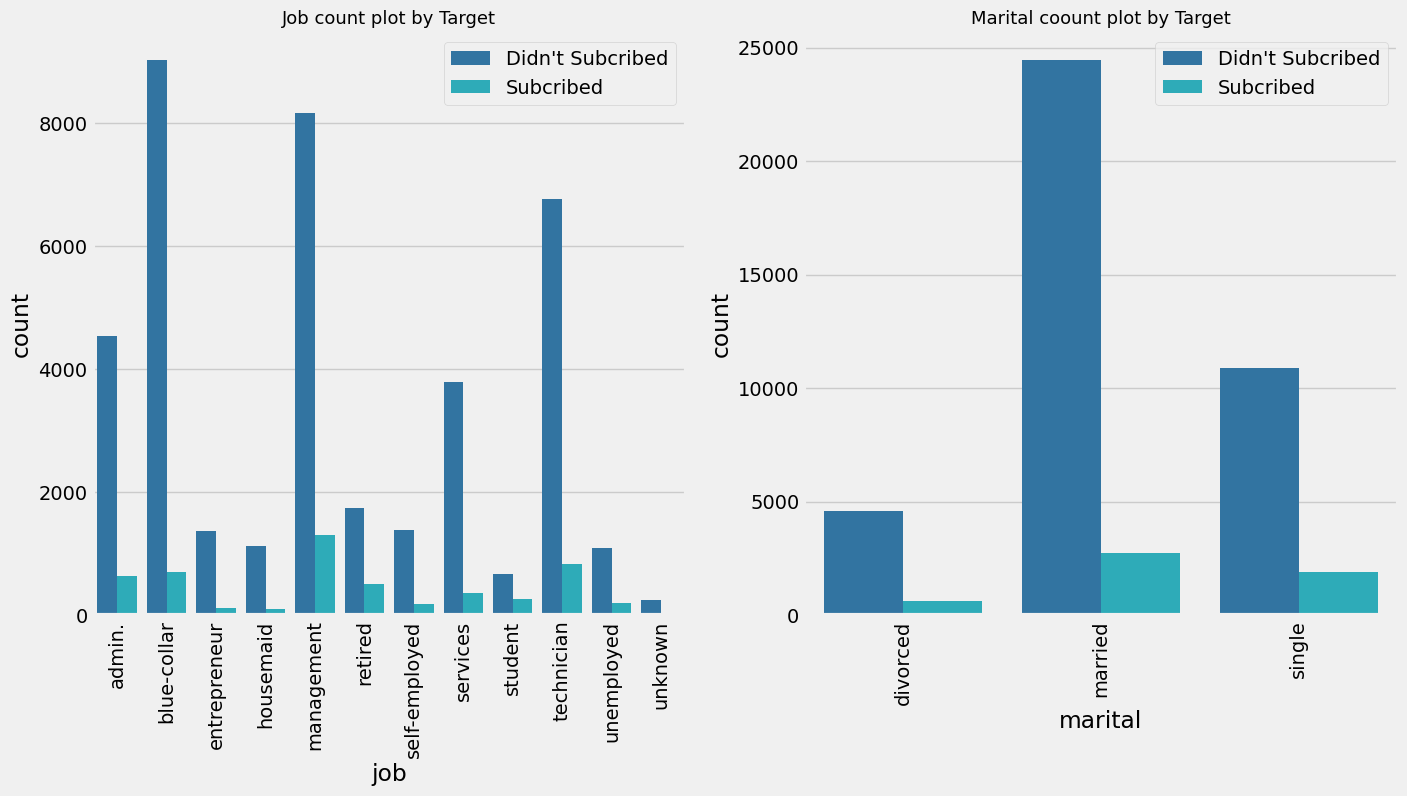

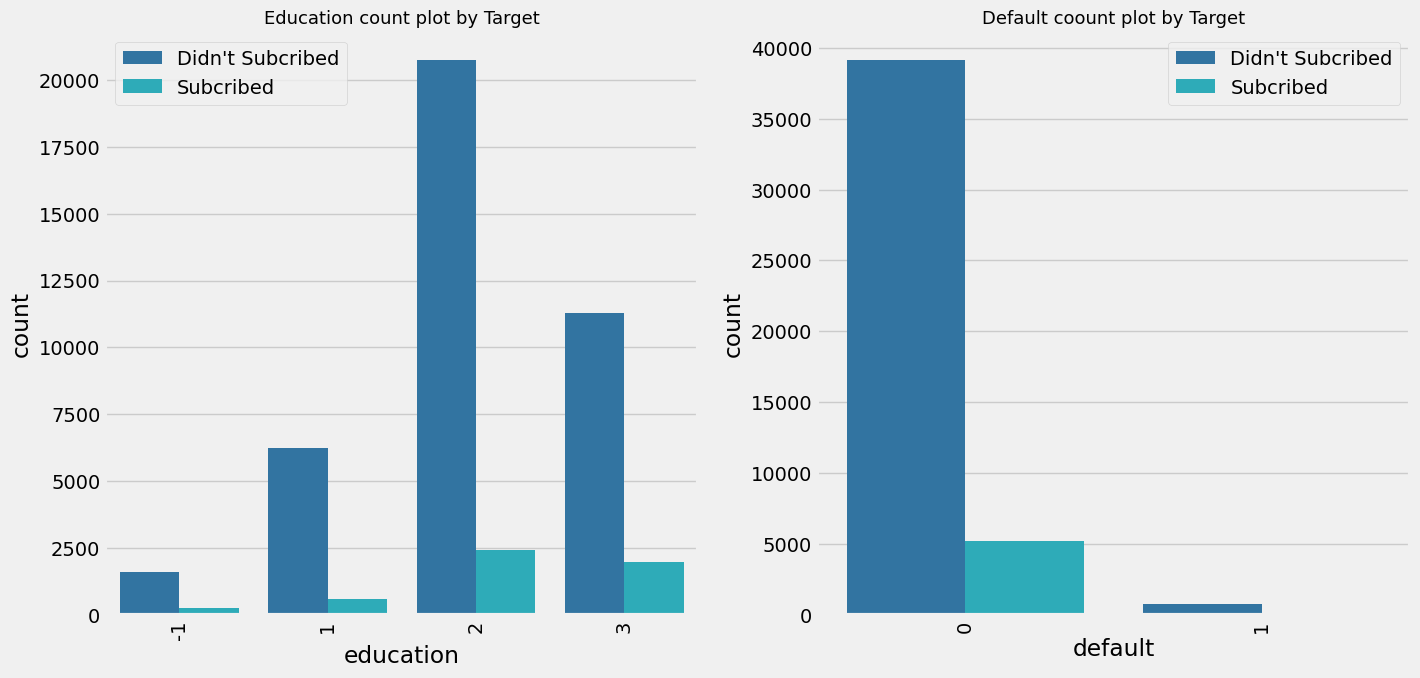

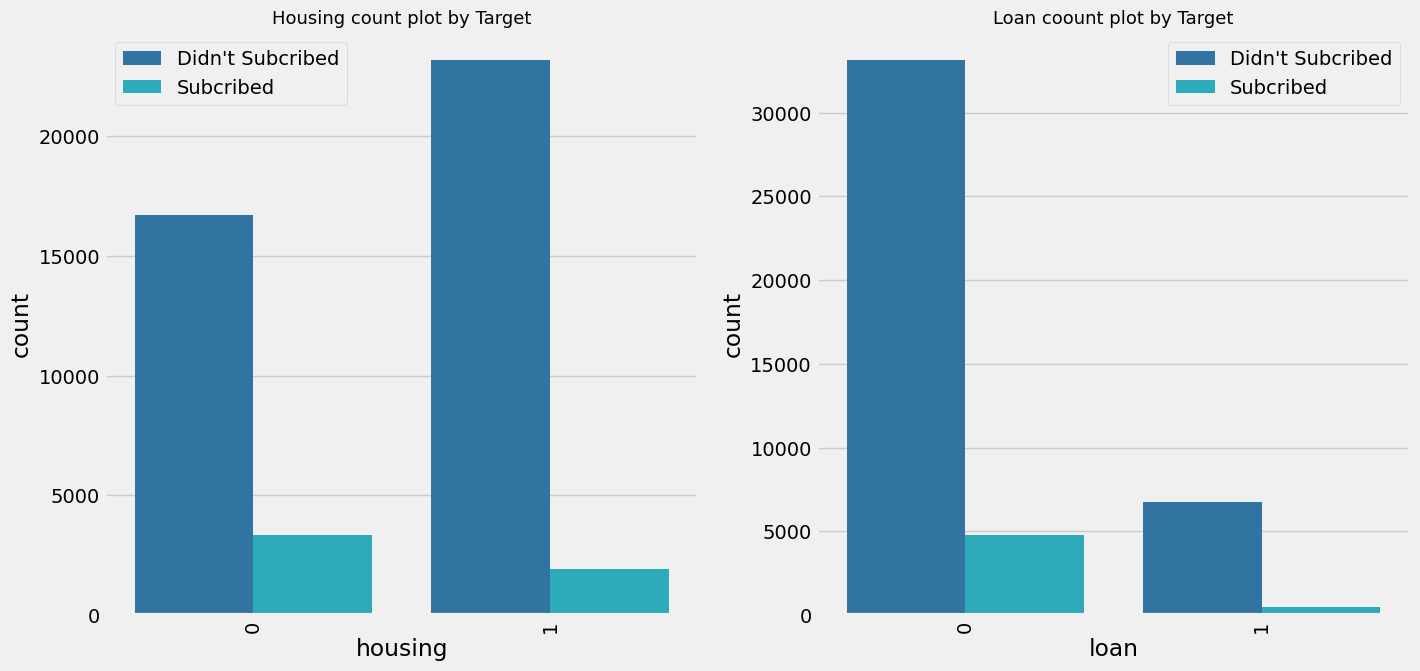

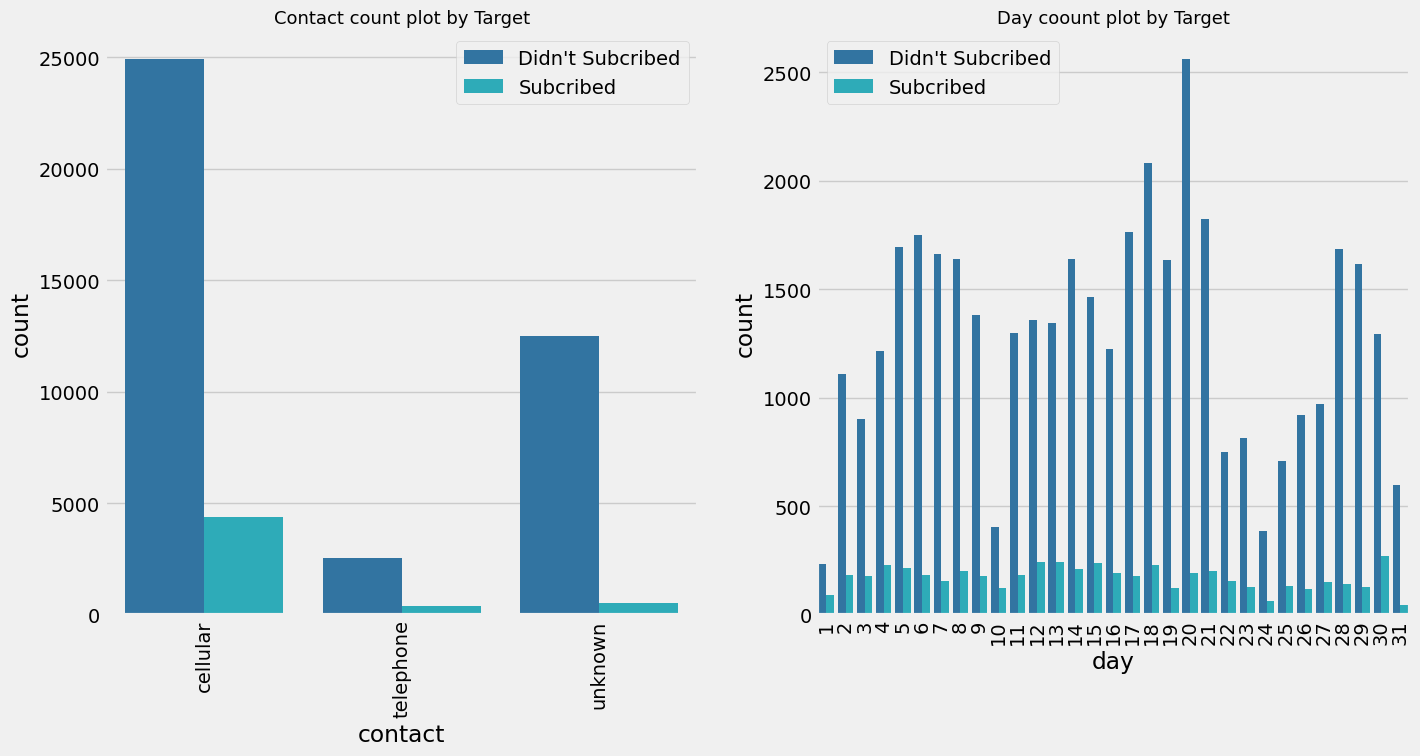

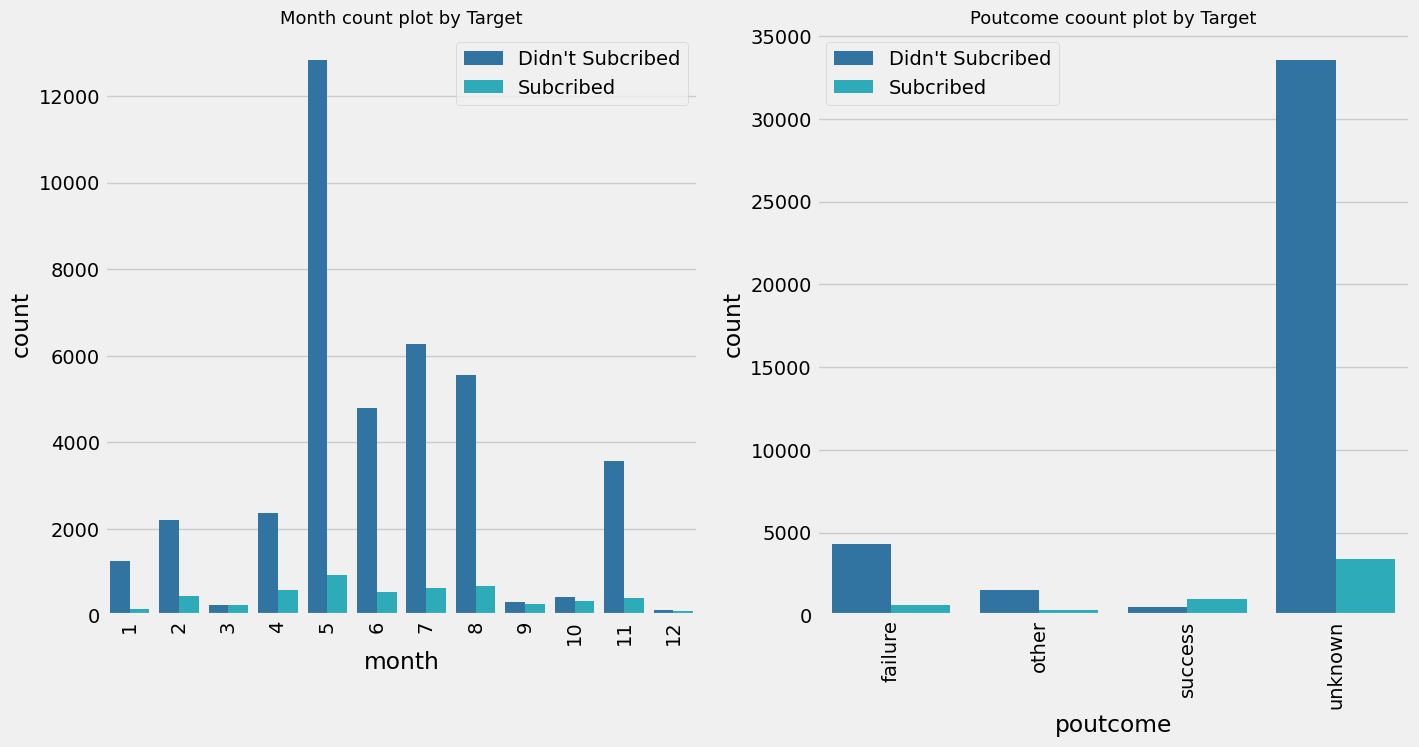

In [ ]:
#Cell 10
# Subscribe and didn't subscribe for categorical columns
target_count(bank, 'job', 'marital')
target_count(bank, 'education', 'default')
target_count(bank, 'housing', 'loan')
target_count(bank, 'contact', 'day')
target_count(bank, 'month', 'poutcome')

Age column --------------------------------------------------------------------------------------------------------------


age      job   marital education default  balance housing loan  \
29158   83  retired   married         1       0      425       0    0   
29261   75  retired  divorced         1       0       46       0    0   
29263   75  retired   married         1       0     3324       0    0   
29322   83  retired   married         3       0     6236       0    0   
29865   75  retired  divorced         1       0     3881       1    0   

         contact day month  duration  campaign  pdays  previous poutcome  \
29158  telephone   2     2       912         1     -1         0  unknown   
29261   cellular   2     2       294         1     -1         0  unknown   
29263   cellular   2     2       149         1     -1         0  unknown   
29322   cellular   2     2       283         2     -1         0  unknown   
29865   cellular   4     2       136         3     -1         0  unknown   

      Target  
29158      0  
29261      0  
29263      0  
29322      0  
29865      1

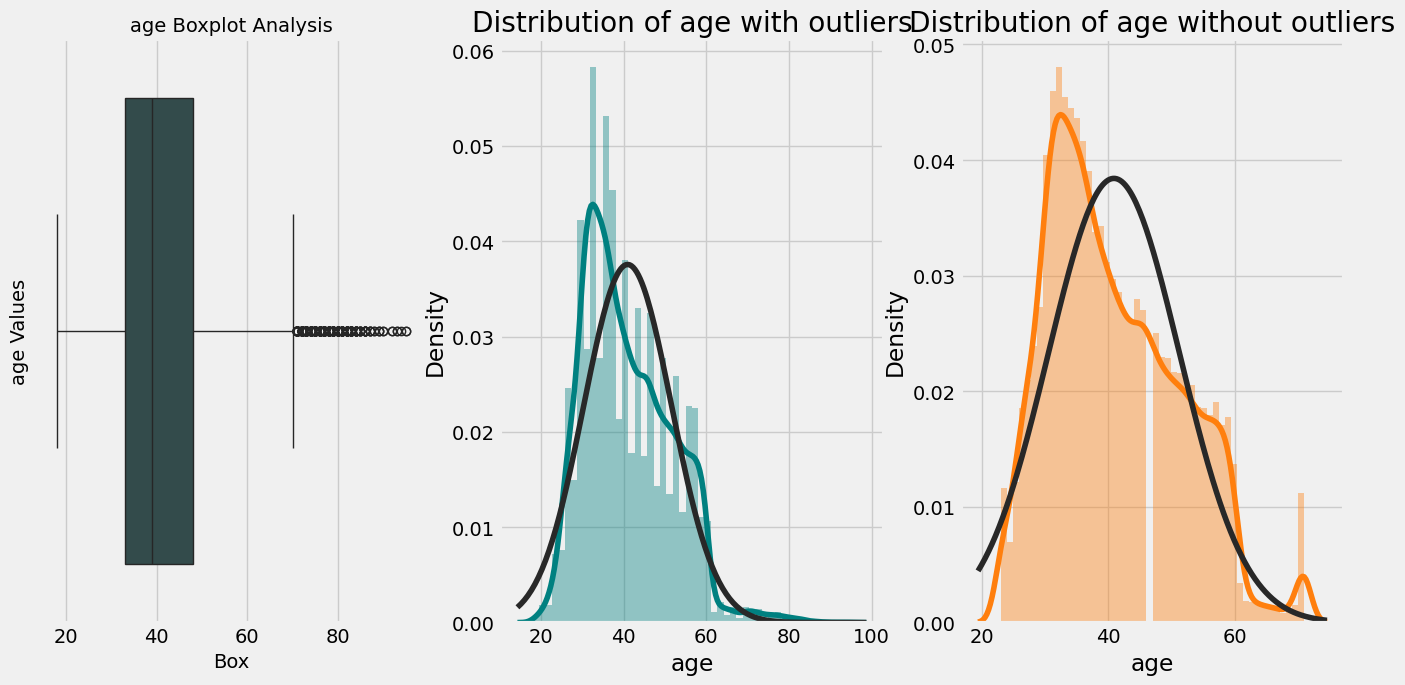

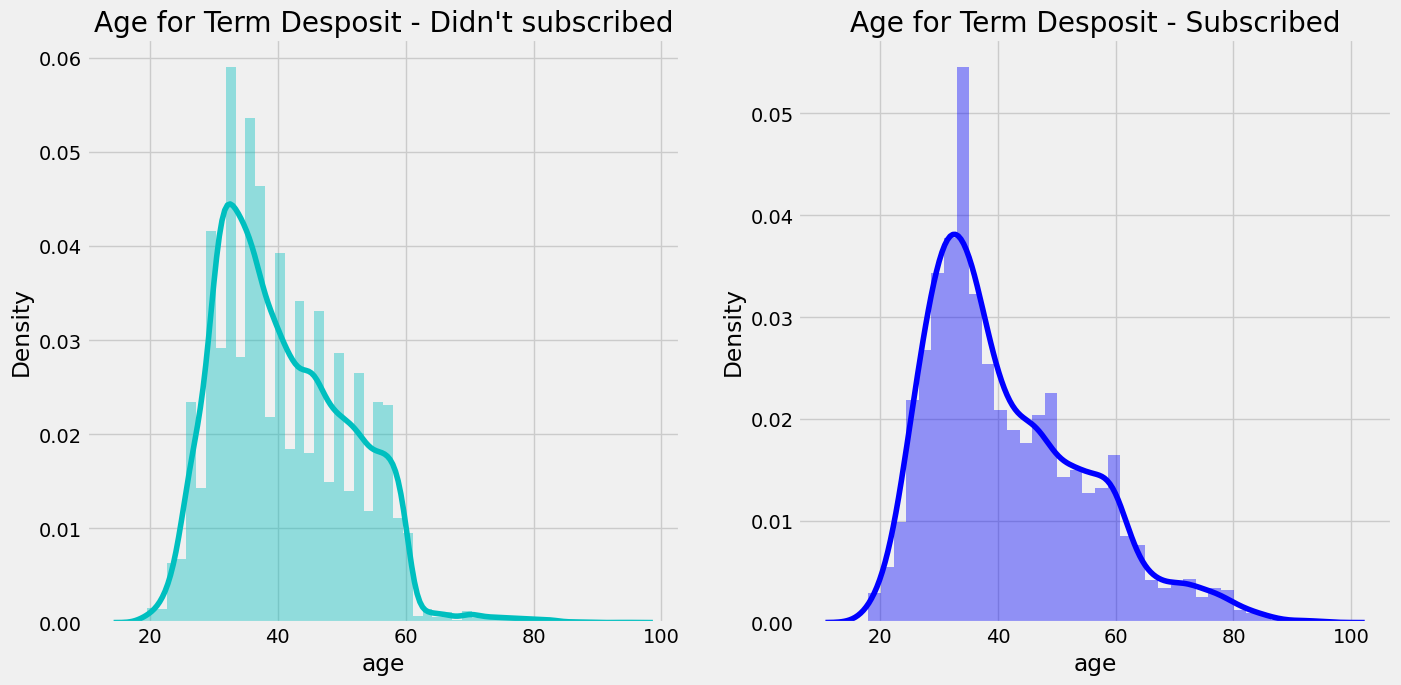

In [ ]:
#Cell 11
# Outlier, distribution for 'age' column
Q3 = bank['age'].quantile(0.75)
Q1 = bank['age'].quantile(0.25)
IQR = Q3 - Q1

print('Age column', '--'*55)
display(bank.loc[(bank['age'] < (Q1 - 1.5 * IQR)) | (bank['age'] > (Q3 + 1.5 * IQR))].head())

odp_plots(bank, 'age')

# Distribution of 'age' by 'Target'
target_plot(bank, 'age')

Balance column --------------------------------------------------------------------------------------------------------------


age          job   marital education default  balance housing loan  \
34    51   management   married         3       0    10635       1    0   
65    51   management   married         3       0     6530       1    0   
69    35  blue-collar    single         2       0    12223       1    1   
70    57  blue-collar   married         2       0     5935       1    1   
186   40     services  divorced        -1       0     4384       1    0   

     contact day month  duration  campaign  pdays  previous poutcome Target  
34   unknown   5     5       336         1     -1         0  unknown      0  
65   unknown   5     5        91         1     -1         0  unknown      0  
69   unknown   5     5       177         1     -1         0  unknown      0  
70   unknown   5     5       258         1     -1         0  unknown      0  
186  unknown   5     5       315         1     -1         0  unknown      0

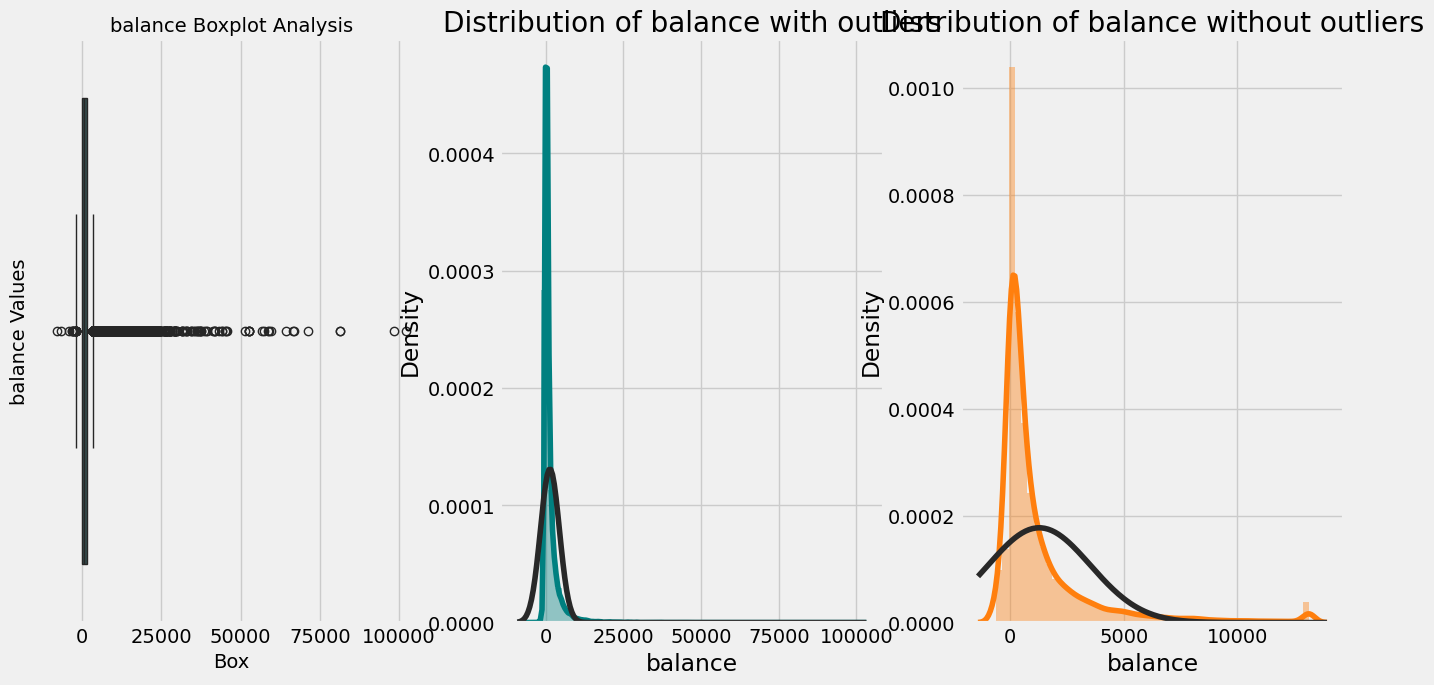

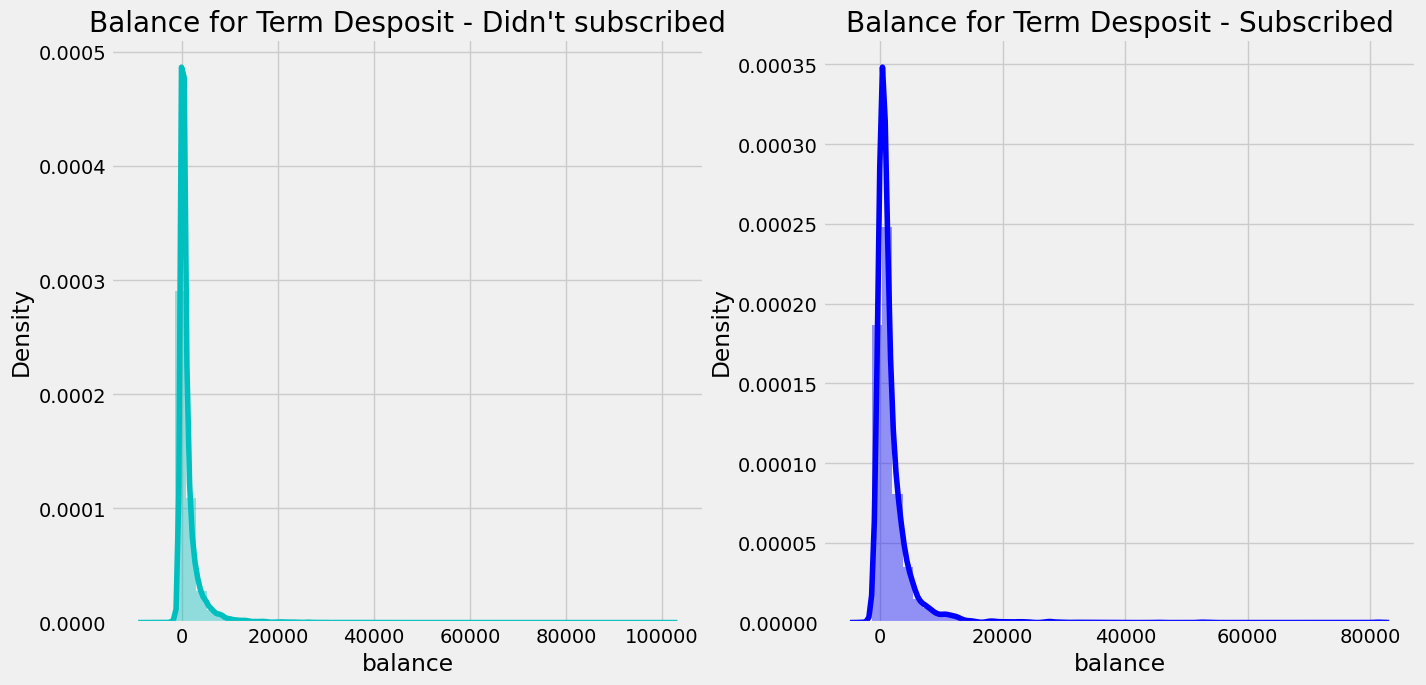

In [ ]:
#Cell 12
# Outlier, distribution for 'balance' column
Q3 = bank['balance'].quantile(0.75)
Q1 = bank['balance'].quantile(0.25)
IQR = Q3 - Q1
print('Balance column', '--'*55)
display(bank.loc[(bank['balance'] < (Q1 - 1.5 * IQR)) | (bank['balance'] > (Q3 + 1.5 * IQR))].head())

odp_plots(bank, 'balance')

# Distribution of 'balance' by 'Target'
target_plot(bank, 'balance')

Duration column ------------------------------------------------------------------------------------------------------------


age         job   marital education default  balance housing loan  \
37   53  technician   married         2       0       -3       0    0   
43   54     retired   married         2       0      529       1    0   
53   42      admin.    single         2       0      -76       1    0   
59   46    services   married         1       0      179       1    0   
61   53  technician  divorced         2       0      989       1    0   

    contact day month  duration  campaign  pdays  previous poutcome Target  
37  unknown   5     5      1666         1     -1         0  unknown      0  
43  unknown   5     5      1492         1     -1         0  unknown      0  
53  unknown   5     5       787         1     -1         0  unknown      0  
59  unknown   5     5      1778         1     -1         0  unknown      0  
61  unknown   5     5       812         1     -1         0  unknown      0

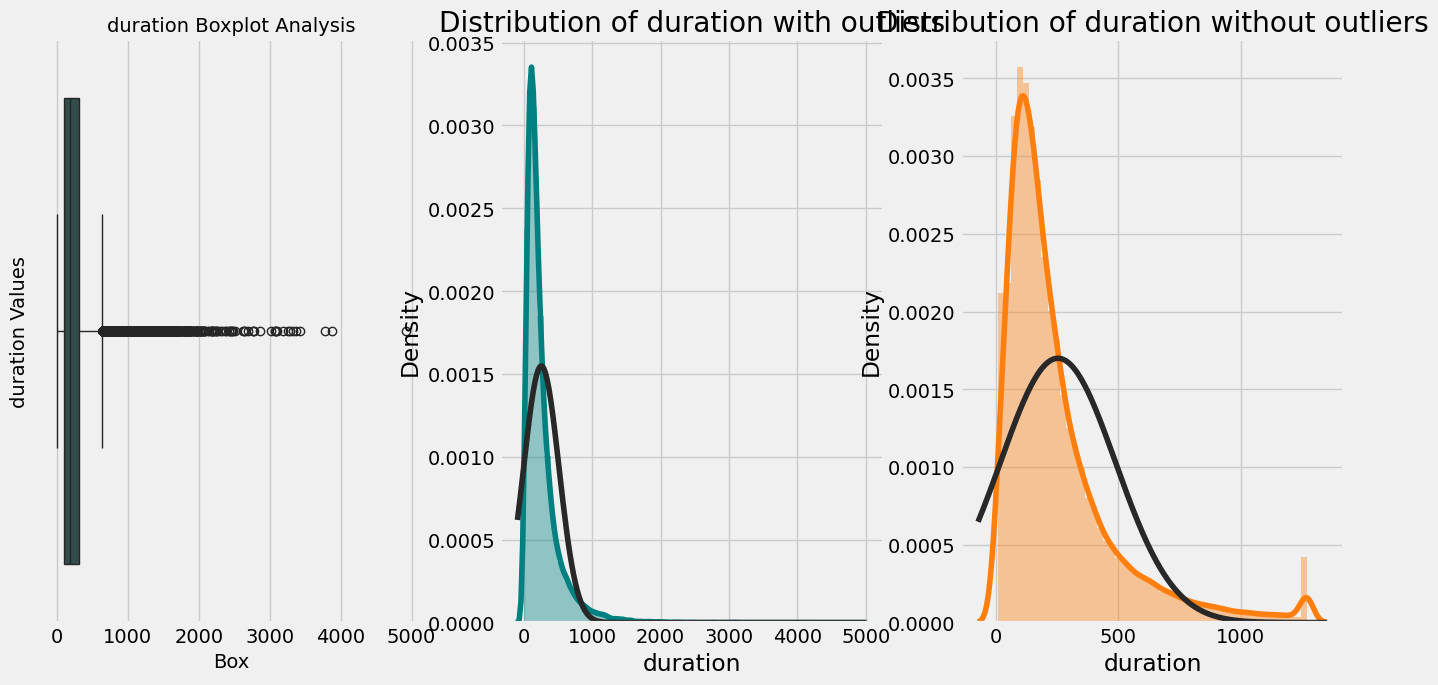

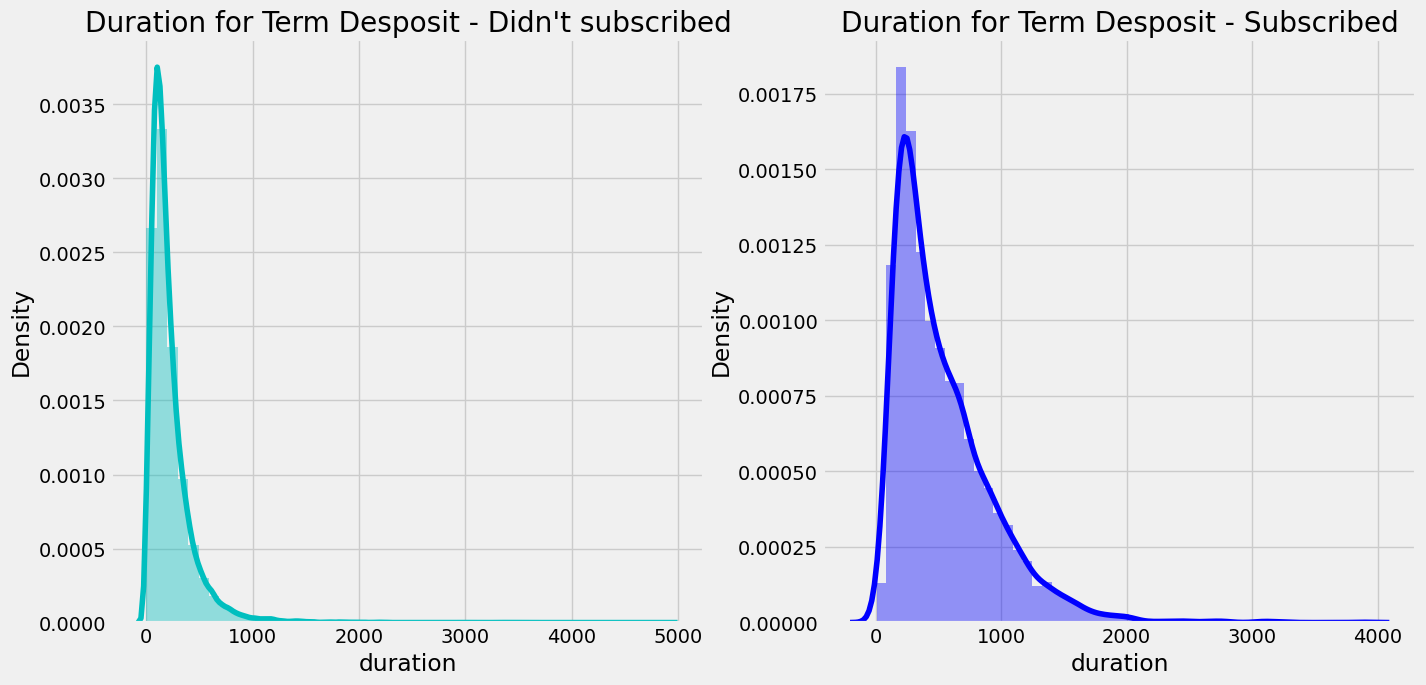

In [ ]:
#Cell 13
# Outlier, distribution for 'duration' column
Q3 = bank['duration'].quantile(0.75)
Q1 = bank['duration'].quantile(0.25)
IQR = Q3 - Q1

print('Duration column', '--'*54)
display(bank.loc[(bank['duration'] < (Q1 - 1.5 * IQR)) | (bank['duration'] > (Q3 + 1.5 * IQR))].head())

odp_plots(bank, 'duration')

# Distribution of 'duration' by 'Target'
target_plot(bank, 'duration')

Campaign column ------------------------------------------------------------------------------------------------------------


age         job  marital education default  balance housing loan  \
758    59    services  married         2       0      307       1    1   
780    30      admin.  married         2       0        4       0    0   
906    27    services   single         2       0        0       1    0   
1103   52  technician  married        -1       0      133       1    0   
1105   43      admin.  married         3       0     1924       1    0   

      contact day month  duration  campaign  pdays  previous poutcome Target  
758   unknown   6     5       250         7     -1         0  unknown      0  
780   unknown   7     5       172         8     -1         0  unknown      0  
906   unknown   7     5       388         7     -1         0  unknown      0  
1103  unknown   7     5       253         8     -1         0  unknown      0  
1105  unknown   7     5       244         7     -1         0  unknown      0

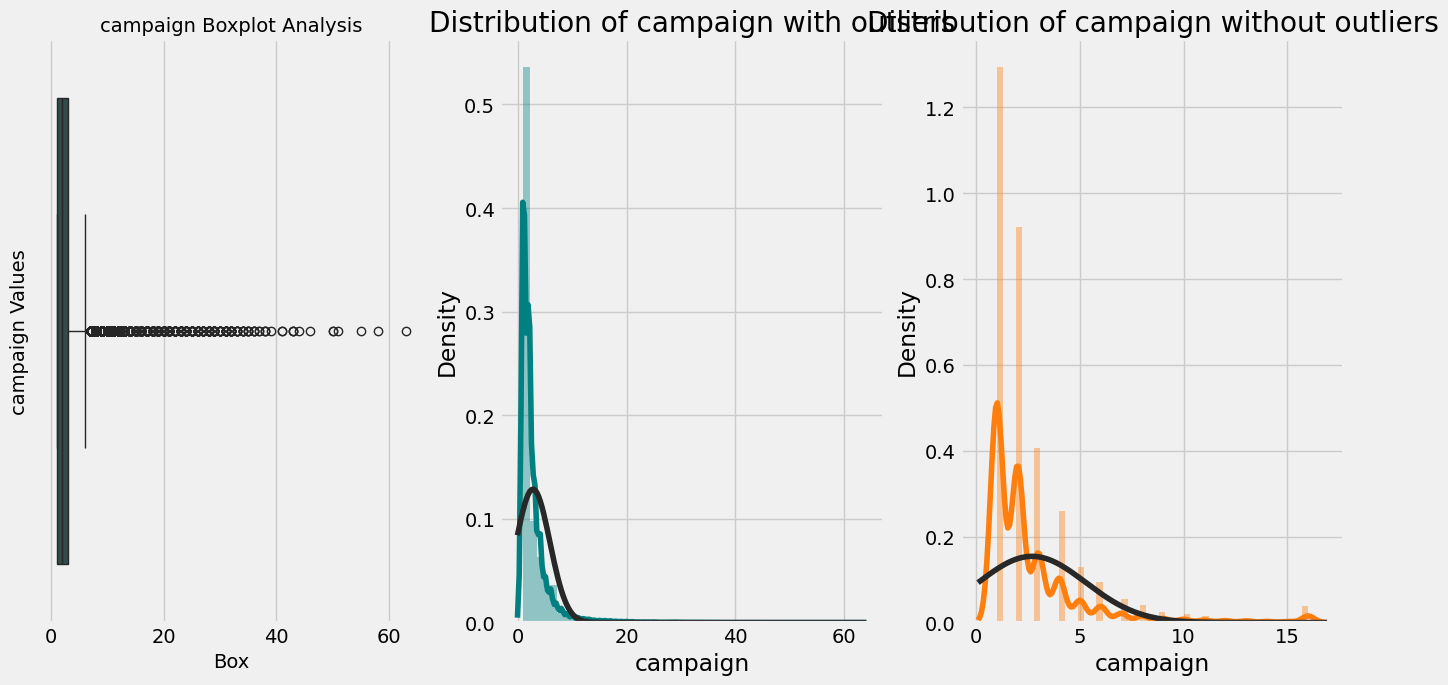

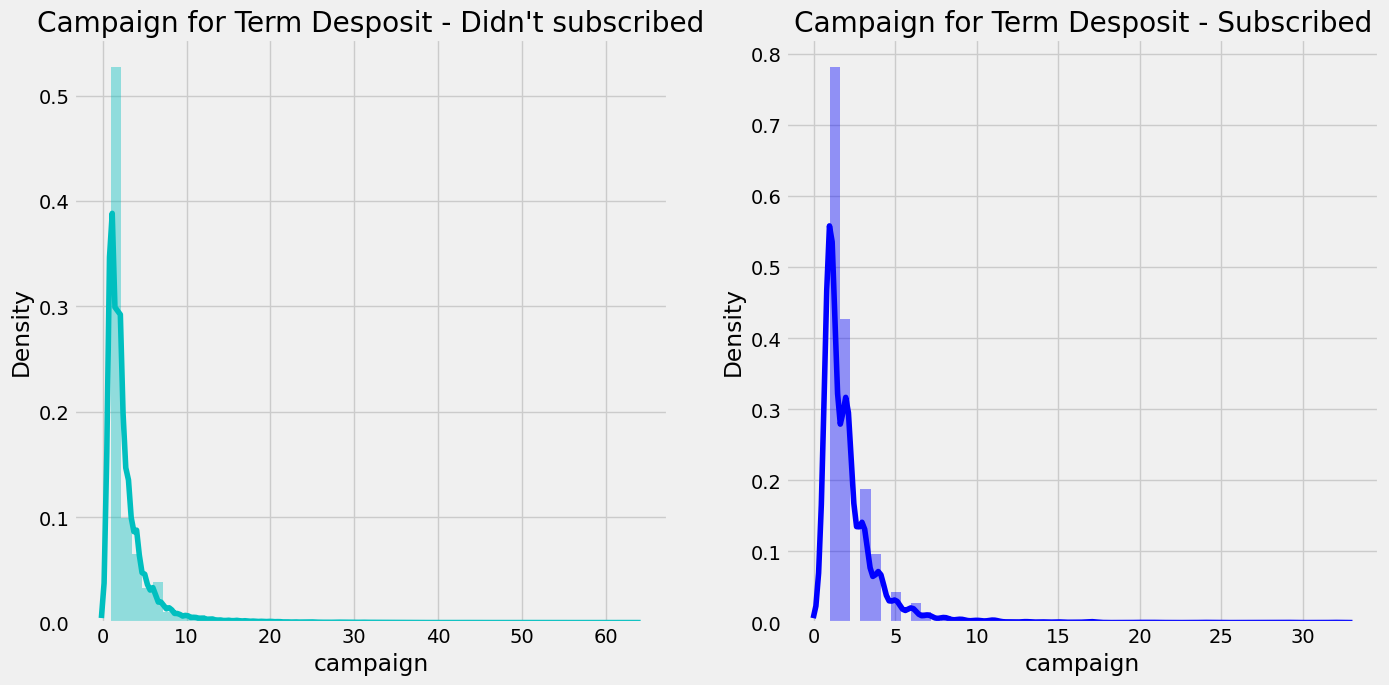

In [ ]:
#Cell 14
# Outlier, distribution for 'campaign' column
Q3 = bank['campaign'].quantile(0.75)
Q1 = bank['campaign'].quantile(0.25)
IQR = Q3 - Q1

print('Campaign column', '--'*54)
display(bank.loc[(bank['campaign'] < (Q1 - 1.5 * IQR)) | (bank['campaign'] > (Q3 + 1.5 * IQR))].head())

odp_plots(bank, 'campaign')

# Distribution of 'campaign' by 'Target'
target_plot(bank, 'campaign')

In [ ]:
#Cell 15
# Outlier, distribution for 'pdays' column
Q3 = bank['pdays'].quantile(0.75)
Q1 = bank['pdays'].quantile(0.25)
IQR = Q3 - Q1

print('Pdays column', '--'*55)
display(bank.loc[(bank['pdays'] < (Q1 - 1.5 * IQR)) | (bank['pdays'] > (Q3 + 1.5 * IQR))].head())

# Check outlier in 'pdays', not considering -1
pdays = bank.loc[bank['pdays'] > 0, ['pdays', 'Target']]
pdays = pd.DataFrame(pdays, columns = ['pdays', 'Target'])
odp_plots(pdays, 'pdays')

# Distribution of 'pdays' by 'Target', not considering -1
target_plot(pdays, 'pdays')

Previous column ------------------------------------------------------------------------------------------------------------


age         job  marital education default  balance housing loan  \
24060   33      admin.  married         3       0      882       0    0   
24062   42      admin.   single         2       0     -247       1    1   
24064   33    services  married         2       0     3444       1    0   
24072   36  management  married         3       0     2415       1    0   
24077   36  management  married         3       0        0       1    0   

         contact day month  duration  campaign  pdays  previous poutcome  \
24060  telephone  21    10        39         1    151         3  failure   
24062  telephone  21    10       519         1    166         1    other   
24064  telephone  21    10       144         1     91         4  failure   
24072  telephone  22    10        73         1     86         4    other   
24077  telephone  23    10       140         1    143         3  failure   

      Target  
24060      0  
24062      1  
24064      1  
24072      0  
24077      1

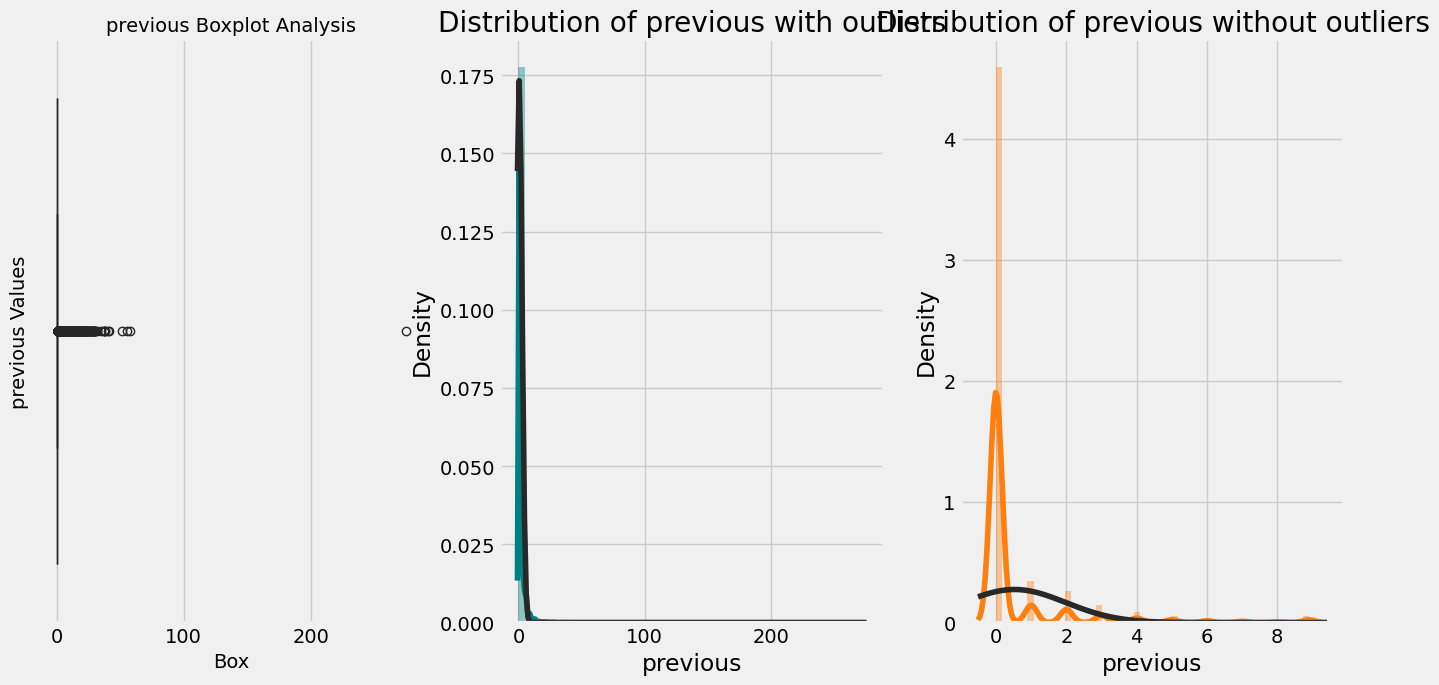

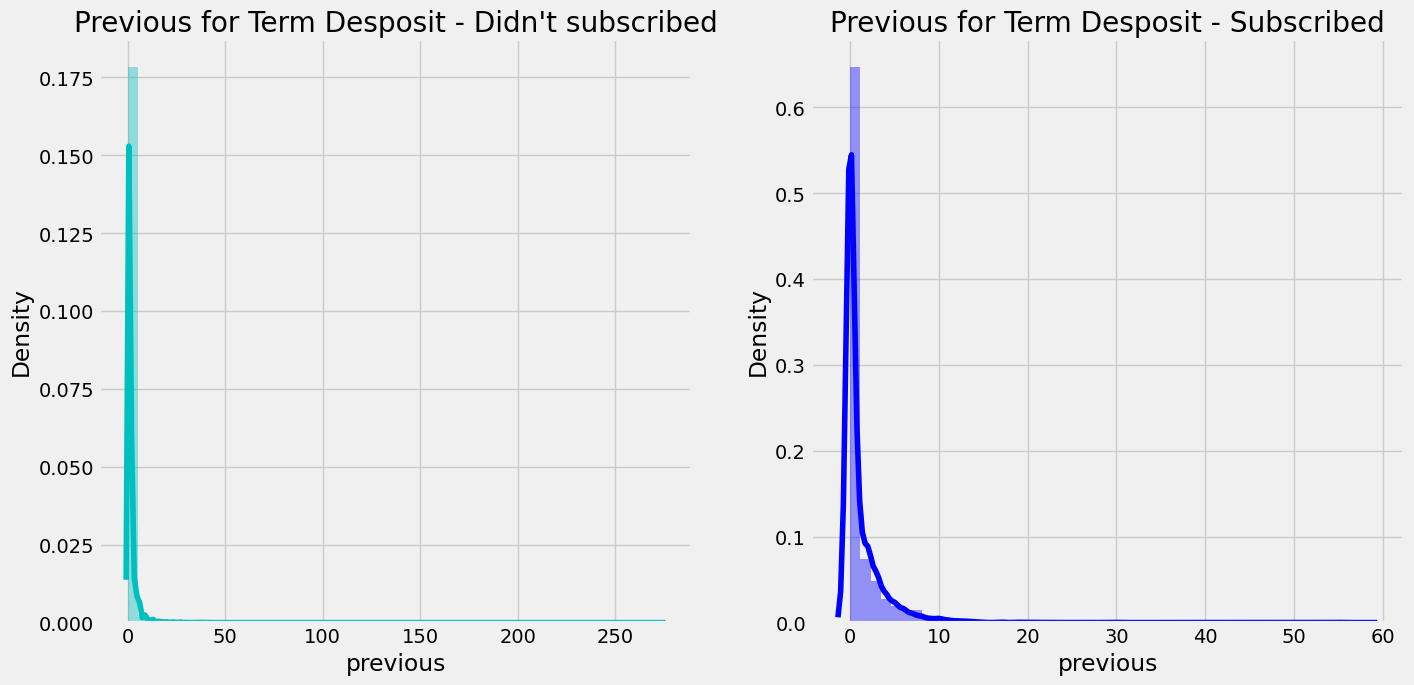

In [ ]:
#Cell 16
# Outlier, distribution and probability plot for 'previous' column
Q3 = bank['previous'].quantile(0.75)
Q1 = bank['previous'].quantile(0.25)
IQR = Q3 - Q1

print('Previous column', '--'*54)
display(bank.loc[(bank['previous'] < (Q1 - 1.5 * IQR)) | (bank['previous'] > (Q3 + 1.5 * IQR))].head())

odp_plots(bank, 'previous')

# Distribution of 'previous' by 'Target'
target_plot(bank, 'previous')

In [ ]:
#Cell 17
print('Categorical Columns: \n{}'.format(list(bank.select_dtypes('category').columns)))
print('\nNumerical Columns: \n{}'.format(list(bank.select_dtypes(exclude = 'category').columns)))

Categorical Columns: 
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'day', 'month', 'poutcome', 'Target']

Numerical Columns: 
['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']


In [ ]:
#Cell 18
# Removing outliers with upper and lower percentile values being 99 and 1, respectively
bank_nulls = bank.copy(deep = True)
columns = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

for col in columns:
    upper_lim = np.percentile(bank_nulls[col].values, 99)
    lower_lim = np.percentile(bank_nulls[col].values, 1)
    bank_nulls.loc[(bank_nulls[col] > upper_lim), col] = np.nan
    bank_nulls.loc[(bank_nulls[col] < lower_lim), col] = np.nan

print('Column for which outliers where removed with upper and lower percentile values: \n', columns)

Column for which outliers where removed with upper and lower percentile values: 
 ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']


In [ ]:
#Cell 19
# pd.get_dummies
cols_to_transform = ['job', 'marital', 'contact', 'poutcome']
bank_nulls = pd.get_dummies(bank_nulls, columns = cols_to_transform) #, drop_first = True)

print('Got dummies for \n', cols_to_transform)
bank_nulls.info()

Got dummies for 
 ['job', 'marital', 'contact', 'poutcome']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 35 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   age                44473 non-null  float64 
 1   education          45211 non-null  category
 2   default            45211 non-null  category
 3   balance            44308 non-null  float64 
 4   housing            45211 non-null  category
 5   loan               45211 non-null  category
 6   day                45211 non-null  category
 7   month              45211 non-null  category
 8   duration           44341 non-null  float64 
 9   campaign           44760 non-null  float64 
 10  pdays              44826 non-null  float64 
 11  previous           44758 non-null  float64 
 12  Target             45211 non-null  category
 13  job_admin.         45211 non-null  uint8   
 14  job_blue-collar    45211 non-null  uint8  

In [ ]:
#Cell 20
# Convert 'astype' of categorical columns to integer for getting it ready for MICE
columns = ['education', 'default', 'housing', 'loan', 'day', 'month', 'Target']
for col in columns:
    bank_nulls[col] = bank_nulls[col].astype('float')

In [ ]:
#Cell 21
!pip install fancyimpute
from fancyimpute import IterativeImputer

# Assuming bank_nulls is your DataFrame with missing values
imputer = IterativeImputer()
bank_imputed = imputer.fit_transform(bank_nulls)

# Convert the imputed array back to a DataFrame
bank_imputed = pd.DataFrame(bank_imputed, columns=bank_nulls.columns)

# Display the descriptions
display(bank.describe(include='all').T, bank_imputed.describe(include='all').T)


  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 2.7 MB/s eta 0:00:00
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29881 sha256=87f4d1842b426c108a39304effdbd1eec0965f860e7946142fc0cacedf04e8c6
  Stored in directory: /root/.cache/pip/wheels/7b/0c/d3/ee82d1fbdcc0858d96434af108608d01703505d453720c84ed
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11330 sha256=2855a8ef0b333d2e2cd97b6c4587649f567c086a81407b09e2b69936d868cc8b
  Stored in directory: /root/.cache/pip/wheels/46/06/a5/45a724630562413c374e29c08732411d496092408b3a7bf754
Successfully built fancyimpute knnimpute


count unique          top     freq         mean          std  \
age        45211.0    NaN          NaN      NaN     40.93621    10.618762   
job          45211     12  blue-collar     9732          NaN          NaN   
marital      45211      3      married    27214          NaN          NaN   
education  45211.0    4.0          2.0  23202.0          NaN          NaN   
default    45211.0    2.0          0.0  44396.0          NaN          NaN   
balance    45211.0    NaN          NaN      NaN  1362.272058  3044.765829   
housing    45211.0    2.0          1.0  25130.0          NaN          NaN   
loan       45211.0    2.0          0.0  37967.0          NaN          NaN   
contact      45211      3     cellular    29285          NaN          NaN   
day        45211.0   31.0         20.0   2752.0          NaN          NaN   
month      45211.0   12.0          5.0  13766.0          NaN          NaN   
duration   45211.0    NaN          NaN      NaN    258.16308   257.527812   
campaign   45211.0    NaN          NaN      NaN     2.763841     3.098021   
pdays      45211.0    NaN          NaN      NaN    40.197828   100.128746   
previous   45211.0    NaN          NaN      NaN     0.580323     2.303441   
poutcome     45211      4      unknown    36959          NaN          NaN   
Target     45211.0    2.0          0.0  39922.0          NaN          NaN   

              min    25%    50%     75%       max  
age          18.0   33.0   39.0    48.0      95.0  
job           NaN    NaN    NaN     NaN       NaN  
marital       NaN    NaN    NaN     NaN       NaN  
education     NaN    NaN    NaN     NaN       NaN  
default       NaN    NaN    NaN     NaN       NaN  
balance   -8019.0   72.0  448.0  1428.0  102127.0  
housing       NaN    NaN    NaN     NaN       NaN  
loan          NaN    NaN    NaN     NaN       NaN  
contact       NaN    NaN    NaN     NaN       NaN  
day           NaN    NaN    NaN     NaN       NaN  
month         NaN    NaN    NaN     NaN       NaN  
duration      0.0  103.0  180.0   319.0    4918.0  
campaign      1.0    1.0    2.0     3.0      63.0  
pdays        -1.0   -1.0   -1.0    -1.0     871.0  
previous      0.0    0.0    0.0     0.0     275.0  
poutcome      NaN    NaN    NaN     NaN       NaN  
Target        NaN    NaN    NaN     NaN       NaN

count         mean          std         min    25%  \
age                45211.0    40.836808    10.072647   23.000000   33.0   
education          45211.0     2.019442     0.902795   -1.000000    2.0   
default            45211.0     0.018027     0.133049    0.000000    0.0   
balance            45211.0  1175.090956  1898.416783 -730.473300   82.0   
housing            45211.0     0.555838     0.496878    0.000000    0.0   
loan               45211.0     0.160226     0.366820    0.000000    0.0   
day                45211.0    15.806419     8.322476    1.000000    8.0   
month              45211.0     6.144655     2.408034    1.000000    5.0   
duration           45211.0   247.423980   211.283036   11.000000  106.0   
campaign           45211.0     2.562198     2.214891    1.000000    1.0   
pdays              45211.0    37.922084    92.398970  -47.635483   -1.0   
previous           45211.0     0.461325     1.208685    0.000000    0.0   
Target             45211.0     0.116985     0.321406    0.000000    0.0   
job_admin.         45211.0     0.114375     0.318269    0.000000    0.0   
job_blue-collar    45211.0     0.215257     0.411005    0.000000    0.0   
job_entrepreneur   45211.0     0.032890     0.178351    0.000000    0.0   
job_housemaid      45211.0     0.027427     0.163326    0.000000    0.0   
job_management     45211.0     0.209197     0.406740    0.000000    0.0   
job_retired        45211.0     0.050076     0.218105    0.000000    0.0   
job_self-employed  45211.0     0.034925     0.183592    0.000000    0.0   
job_services       45211.0     0.091880     0.288860    0.000000    0.0   
job_student        45211.0     0.020747     0.142538    0.000000    0.0   
job_technician     45211.0     0.168034     0.373901    0.000000    0.0   
job_unemployed     45211.0     0.028820     0.167303    0.000000    0.0   
job_unknown        45211.0     0.006370     0.079559    0.000000    0.0   
marital_divorced   45211.0     0.115171     0.319232    0.000000    0.0   
marital_married    45211.0     0.601933     0.489505    0.000000    0.0   
marital_single     45211.0     0.282896     0.450411    0.000000    0.0   
contact_cellular   45211.0     0.647741     0.477680    0.000000    0.0   
contact_telephone  45211.0     0.064276     0.245247    0.000000    0.0   
contact_unknown    45211.0     0.287983     0.452828    0.000000    0.0   
poutcome_failure   45211.0     0.108403     0.310892    0.000000    0.0   
poutcome_other     45211.0     0.040698     0.197592    0.000000    0.0   
poutcome_success   45211.0     0.033421     0.179735    0.000000    0.0   
poutcome_unknown   45211.0     0.817478     0.386278    0.000000    1.0   

                     50%     75%           max  
age                 39.0    48.0     71.703152  
education            2.0     3.0      3.000000  
default              0.0     0.0      1.000000  
balance            467.0  1402.0  13164.000000  
housing              1.0     1.0      1.000000  
loan                 0.0     0.0      1.000000  
day                 16.0    21.0     31.000000  
month                6.0     8.0     12.000000  
duration           183.0   316.0   1269.000000  
campaign             2.0     3.0     16.000000  
pdays               -1.0    -1.0    370.000000  
previous             0.0     0.0      8.000000  
Target               0.0     0.0      1.000000  
job_admin.           0.0     0.0      1.000000  
job_blue-collar      0.0     0.0      1.000000  
job_entrepreneur     0.0     0.0      1.000000  
job_housemaid        0.0     0.0      1.000000  
job_management       0.0     0.0      1.000000  
job_retired          0.0     0.0      1.000000  
job_self-employed    0.0     0.0      1.000000  
job_services         0.0     0.0      1.000000  
job_student          0.0     0.0      1.000000  
job_technician       0.0     0.0      1.000000  
job_unemployed       0.0     0.0      1.000000  
job_unknown          0.0     0.0      1.000000  
marital_divorced     0.0     0.0      1.000000

In [ ]:
#Cell 22
# Checking whether count of 0 in previous is equal to count of -1 in pdays
display(bank_imputed.loc[bank_imputed['previous'] == 0, 'previous'].value_counts().sum(),
        bank_imputed.loc[bank_imputed['pdays'] == -1, 'pdays'].value_counts().sum())

36954

36954

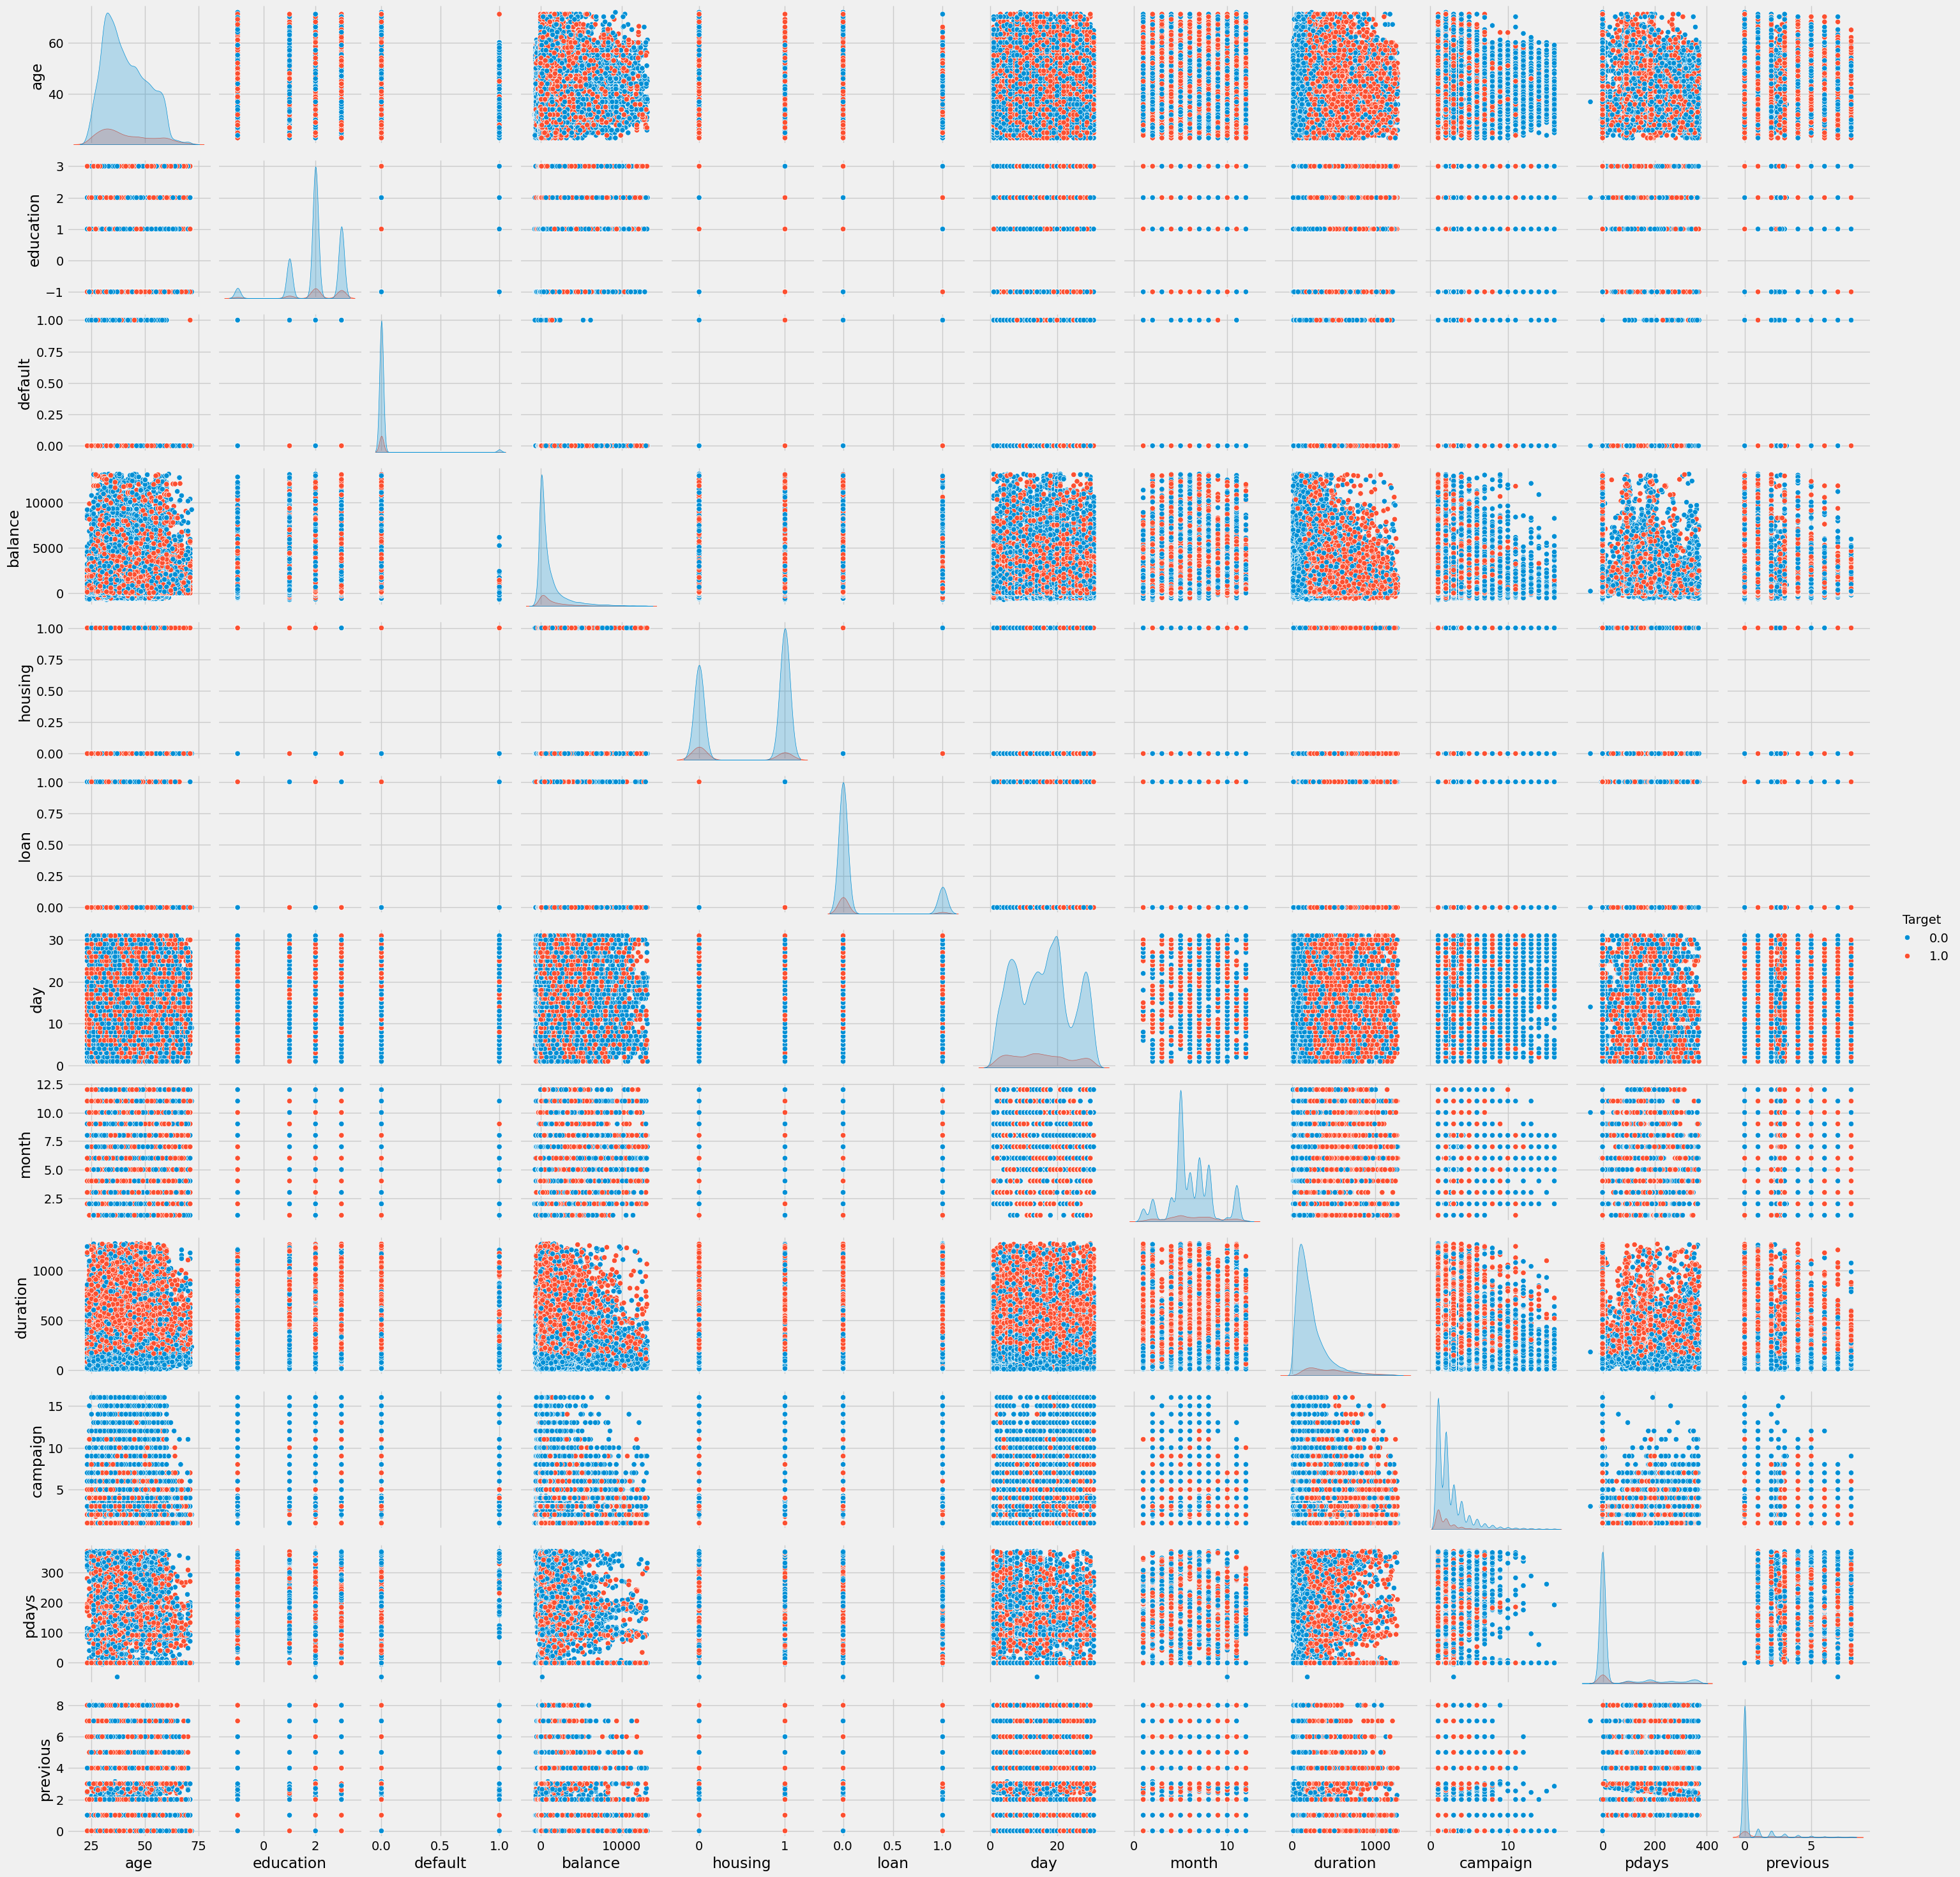

In [ ]:
#Cell 23
img = sns.pairplot(bank_imputed[['age', 'education', 'default', 'balance', 'housing', 'loan', 'day', 'month',
                           'duration', 'campaign', 'pdays', 'previous', 'Target']], hue = 'Target')

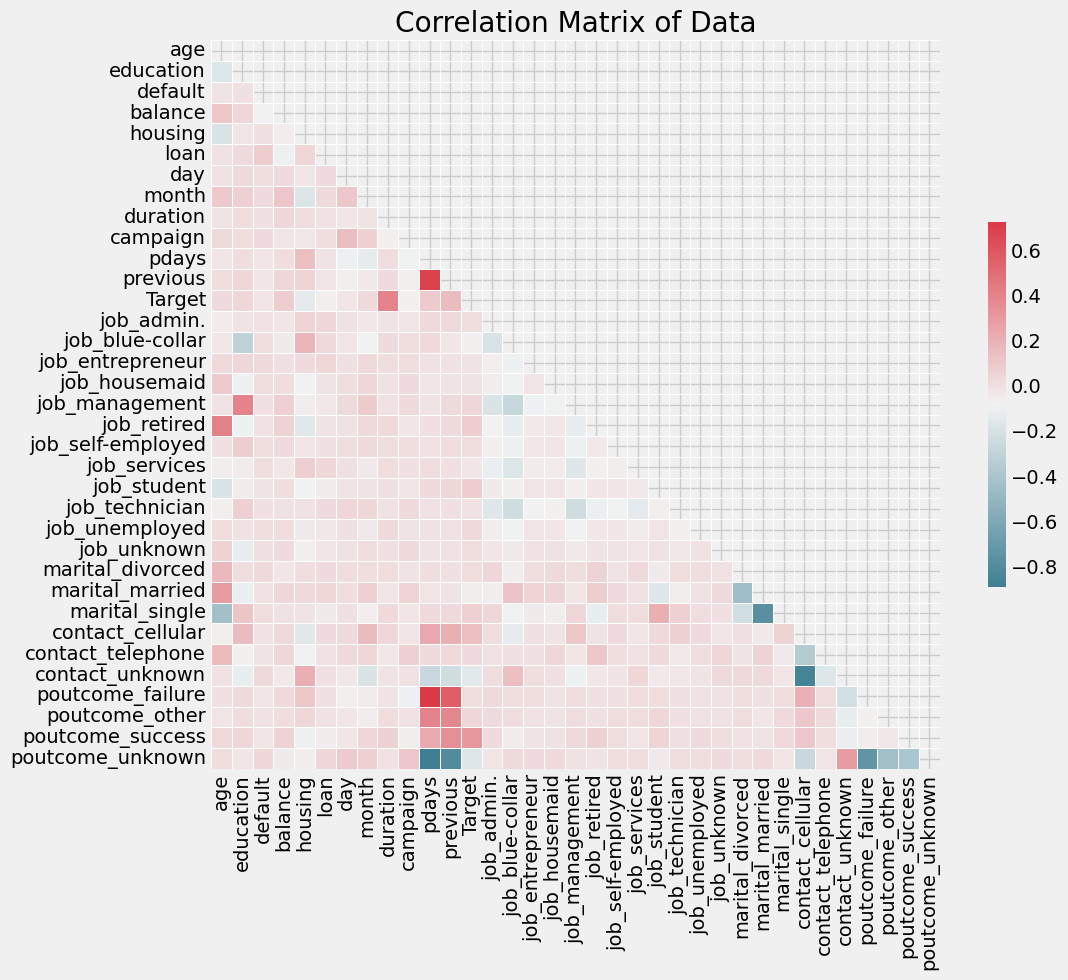

In [ ]:
#Cell 24
corr = bank_imputed.corr()

mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title('Correlation Matrix of Data')
plt.show()

In [ ]:
#Cell 25
# Filter for correlation value greater than 0.8 and less than 1
sort = corr.abs().unstack()
sort = sort.sort_values(kind = "quicksort", ascending = False)
sort[(sort > 0.8) & (sort < 1)]

pdays             poutcome_unknown    0.891234
poutcome_unknown  pdays               0.891234
contact_cellular  contact_unknown     0.862398
contact_unknown   contact_cellular    0.862398
previous          poutcome_unknown    0.806948
poutcome_unknown  previous            0.806948
dtype: float64

In [ ]:
#Cell 26
# Absolute correlation of independent variables with 'Target' i.e. the target variable
absCorrwithDep = []
allVars = bank_imputed.drop('Target', axis = 1).columns

for var in allVars:
    absCorrwithDep.append(abs(bank_imputed['Target'].corr(bank_imputed[var])))

display(pd.DataFrame([allVars, absCorrwithDep], index = ['Variable', 'Correlation']).T.\
        sort_values('Correlation', ascending = False))

Variable Correlation
8            duration    0.398044
32   poutcome_success    0.306788
33   poutcome_unknown    0.167051
11           previous    0.153338
29    contact_unknown    0.150935
4             housing    0.139173
27   contact_cellular    0.135873
10              pdays    0.086591
17        job_retired    0.079245
3             balance    0.076904
20        job_student    0.076897
9            campaign    0.075449
13    job_blue-collar    0.072083
5                loan    0.068185
26     marital_single    0.063526
25    marital_married     0.06026
1           education    0.041634
16     job_management    0.032919
31     poutcome_other    0.031955
6                 day    0.028348
19       job_services    0.027864
2             default    0.022419
22     job_unemployed     0.02039
14   job_entrepreneur    0.019662
7               month    0.018717
15      job_housemaid    0.015195
28  contact_telephone    0.014042
0                 age    0.013461
30   poutcome_failure    0.009885
21     job_technician     0.00897
12         job_admin.    0.005637
24   marital_divorced    0.002772
18  job_self-employed    0.000855
23        job_unknown    0.000267

In [ ]:
#Cell 27
# Creating age groups
bank_imputed.loc[(bank_imputed['age'] < 30), 'age_group'] = 20
bank_imputed.loc[(bank_imputed['age'] >= 30) & (bank_imputed['age'] < 40), 'age_group'] = 30
bank_imputed.loc[(bank_imputed['age'] >= 40) & (bank_imputed['age'] < 50), 'age_group'] = 40
bank_imputed.loc[(bank_imputed['age'] >= 50) & (bank_imputed['age'] < 60), 'age_group'] = 50
bank_imputed.loc[(bank_imputed['age'] >= 60), 'age_group'] = 60

Text(0.5, 1.0, 'Relationship between balance and age group by Target')

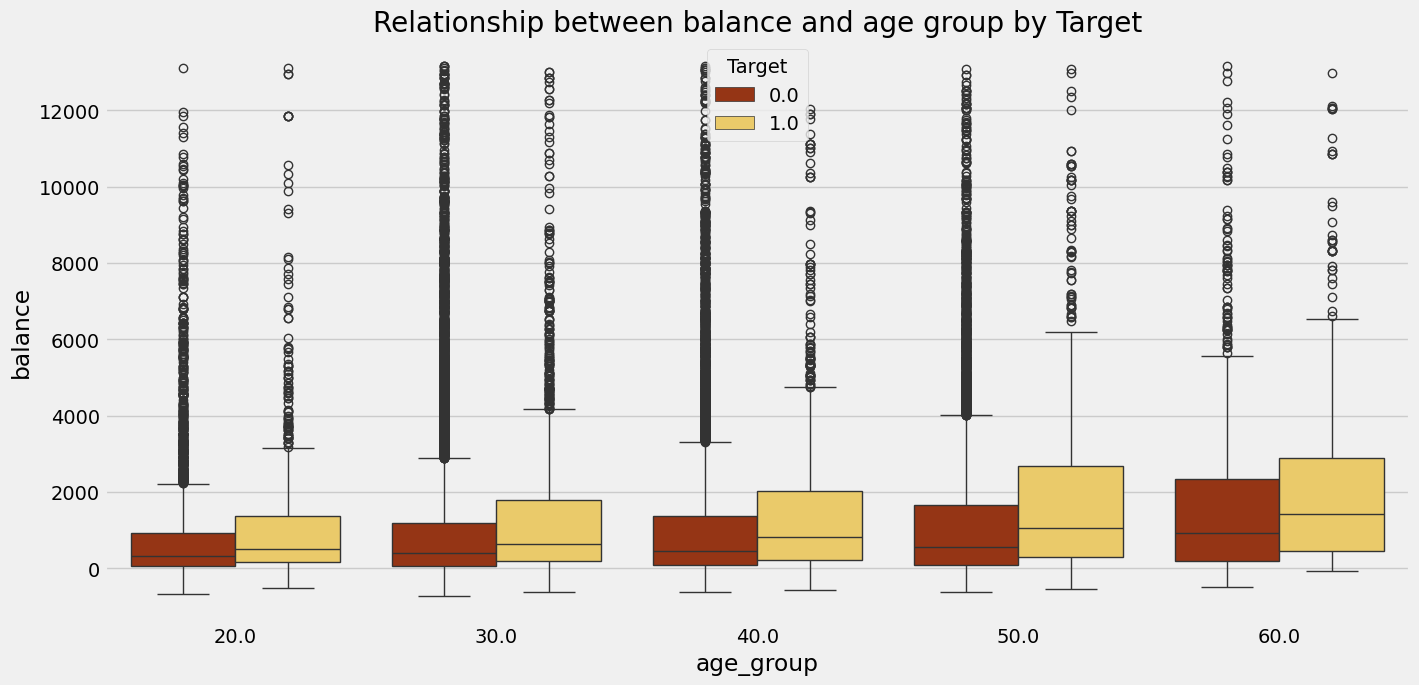

In [ ]:
#Cell 28
# Check relationship between balance and age group by Target
fig = plt.figure(figsize = (15, 7.2))
ax = sns.boxplot(x = 'age_group', y = 'balance', hue = 'Target', palette = 'afmhot', data = bank_imputed)
ax.set_title('Relationship between balance and age group by Target')

Text(0.5, 1.0, 'Relationship between campaign and age group by Target')

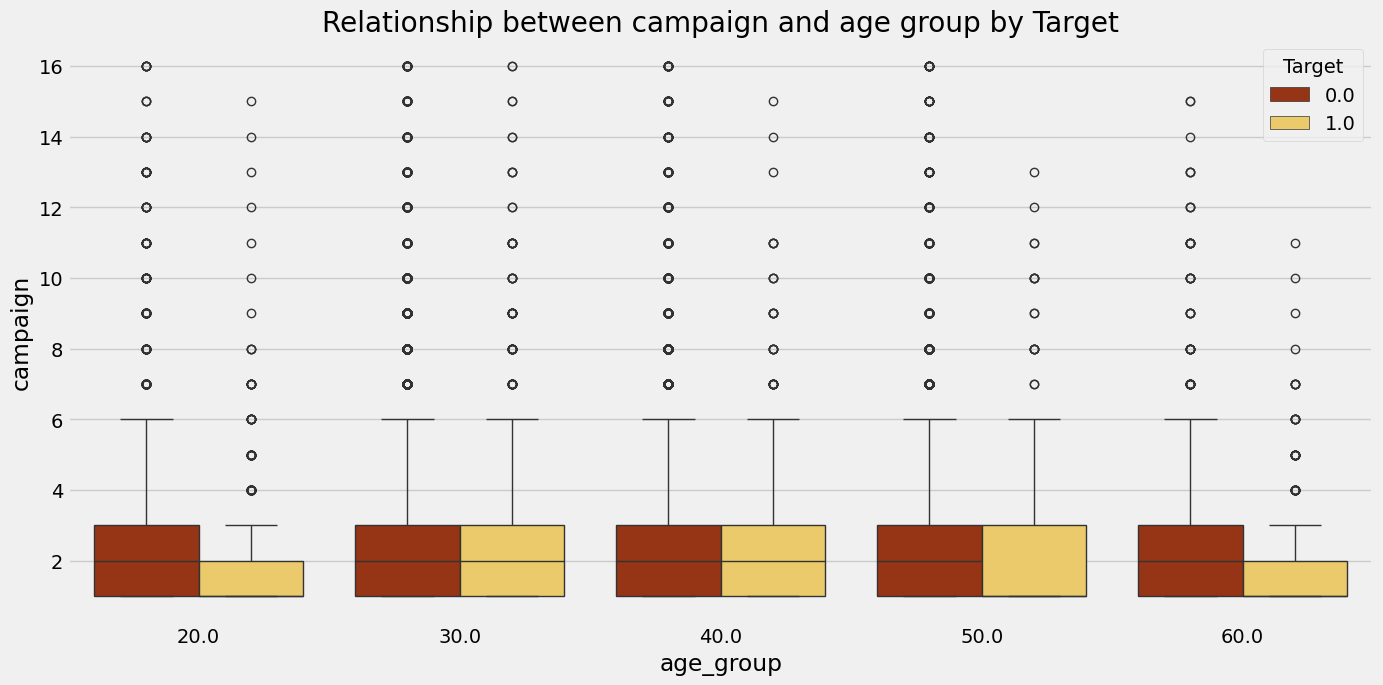

In [ ]:
#Cell 29
# Check relationship between campaign and age group by Target
fig = plt.figure(figsize = (15, 7.2))
ax = sns.boxplot(x = 'age_group', y = 'campaign', hue = 'Target', palette = 'afmhot', data = bank_imputed)
ax.set_title('Relationship between campaign and age group by Target')

#Baseline Model


In [ ]:
#Cell 30
# Separating dependent and independent variables
X = bank_imputed.drop(['Target'], axis = 1)
y = bank_imputed['Target']

# Splitting the data into training and test set in the ratio of 70:30 respectively
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = random_state)

dummy = DummyClassifier(strategy = 'most_frequent', random_state = random_state)
dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_test)

accuracy_ = accuracy_score(y_test, y_pred)
pre_s = precision_score(y_test, y_pred, average = 'binary', pos_label = 1)
re_s = recall_score(y_test, y_pred, average = 'binary', pos_label = 1)
f1_s = f1_score(y_test, y_pred, average = 'binary', pos_label = 1)

pre_m = precision_score(y_test, y_pred, average = 'macro')
re_m = recall_score(y_test, y_pred, average = 'macro')
f1_m = f1_score(y_test, y_pred, average = 'macro')

print('Training Score: ', dummy.score(X_train, y_train).round(3))
print('Test Score: ', dummy.score(X_test, y_test).round(3))

print('Accuracy: ', accuracy_.round(3))
print('Precision Score - Subscribe: ', pre_s.round(3))
print('Recall Score - Subscribe: ', re_s.round(3))
print('f1 Score - Subscribe: ', f1_s.round(3))

print('Precision Score - Macro: ', pre_m.round(3))
print('Recall Score - Macro: ', re_m.round(3))
print('f1 Score - Macro: ', f1_m.round(3))

df = pd.DataFrame([accuracy_.round(3), pre_s.round(3), pre_m.round(3), re_s.round(3),
                   re_m.round(3), f1_s.round(3), f1_m.round(3)], columns = ['Baseline Model']).T
df.columns = ['Accuracy', 'Precision_Subscribe', 'Precision_Macro',
              'Recall_Subscribe', 'Recall_Macro', 'f1_Subscribe', 'f1_Macro']
df

Training Score:  0.883
Test Score:  0.882
Accuracy:  0.882
Precision Score - Subscribe:  0.0
Recall Score - Subscribe:  0.0
f1 Score - Subscribe:  0.0
Precision Score - Macro:  0.441
Recall Score - Macro:  0.5
f1 Score - Macro:  0.469


Accuracy  Precision_Subscribe  Precision_Macro  \
Baseline Model     0.882                  0.0            0.441   

                Recall_Subscribe  Recall_Macro  f1_Subscribe  f1_Macro  
Baseline Model               0.0           0.5           0.0     0.469

In [ ]:
#Cell 31
# Helper function for making prediction and evaluating scores
def train_and_predict(n_splits, base_model, X, y, name, subscribe = 1, oversampling = False):
    features = X.columns
    X = np.array(X)
    y = np.array(y)

    folds = list(StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = random_state).split(X, y))

    train_pred = np.zeros((X.shape[0], len(base_model)))

    accuracy = []

    precision_subscribe = []
    recall_subscribe = []
    f1_subscribe = []

    precision_macro = []
    recall_macro = []
    f1_macro = []

    for i, clf in enumerate(base_model):
        for j, (train, test) in enumerate(folds):

            # Creating train and test sets
            X_train = X[train]
            y_train = y[train]
            X_test = X[test]
            y_test = y[test]

            if oversampling:
                sm = SMOTE(random_state = random_state, sampling_strategy = 'minority')
                X_train_res, y_train_res = sm.fit_resample(X_train, y_train)    #USed Fit_sample to fit_resample

            # fit the model
                clf.fit(X_train_res, y_train_res)

            # Get predictions
                y_true, y_pred = y_test, clf.predict(X_test)

            # Evaluate train and test scores
                train_ = clf.score(X_train_res, y_train_res)
                test_ = clf.score(X_test, y_test)

            else:

            # fit the model
                clf.fit(X_train, y_train)

            # Get predictions
                y_true, y_pred = y_test, clf.predict(X_test)

            # Evaluate train and test scores
                train_ = clf.score(X_train, y_train)
                test_ = clf.score(X_test, y_test)

            # Other scores
            accuracy_ = accuracy_score(y_true, y_pred).round(3)

            precision_b = precision_score(y_true, y_pred, average = 'binary', pos_label = subscribe).round(3)
            recall_b = recall_score(y_true, y_pred, average = 'binary', pos_label = subscribe).round(3)
            f1_b = f1_score(y_true, y_pred, average = 'binary', pos_label = subscribe).round(3)

            precision_m = precision_score(y_true, y_pred, average = 'macro').round(3)
            recall_m = recall_score(y_true, y_pred, average = 'macro').round(3)
            f1_m = f1_score(y_true, y_pred, average = 'macro').round(3)

            print(f'Model- {name.capitalize()} and CV- {j}')
            print('-'*20)
            print('Training Score: {0:.3f}'.format(train_))
            print('Test Score: {0:.3f}'.format(test_))

            print('Accuracy Score: {0:.3f}'.format(accuracy_))

            print('Precision Score - Subscribe: {0:.3f}'.format(precision_b))
            print('Recall Score - Subscribe: {0:.3f}'.format(recall_b))
            print('f1 Score - Subscribe: {0:.3f}'.format(f1_b))

            print('Precision Score - Macro: {0:.3f}'.format(precision_m))
            print('Recall Score - Macro: {0:.3f}'.format(recall_m))
            print('f1 Score - Macro: {0:.3f}'.format(f1_m))
            print('\n')

            ## Appending scores
            accuracy.append(accuracy_)
            precision_subscribe.append(precision_b)
            recall_subscribe.append(recall_b)
            f1_subscribe.append(f1_b)
            precision_macro.append(precision_m)
            recall_macro.append(recall_m)
            f1_macro.append(f1_m)

            # Creating a dataframe of scores
            df = pd.DataFrame([np.mean(accuracy).round(3), np.mean(precision_subscribe).round(3),
                               np.mean(precision_macro).round(3), np.mean(recall_subscribe).round(3),
                               np.mean(recall_macro).round(3), np.mean(f1_subscribe).round(3),
                               np.mean(f1_macro).round(3)], columns = [name]).T
            df.columns = ['Accuracy', 'Precision_Subscribe', 'Precision_Macro',
                          'Recall_Subscribe', 'Recall_Macro', 'f1_Subscribe', 'f1_Macro']

    return df

#Logistic Regression

In [ ]:
#Cell 32
# Separating dependent and independent variables
from sklearn.preprocessing import RobustScaler
X = bank_imputed.drop(['Target'], axis = 1)
y = bank_imputed['Target']

# Applying RobustScaler to make it less prone to outliers
features = X.columns
scaler = RobustScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns = features)

# Scaling the independent variables
Xs = X.apply(zscore)

display(X.shape, Xs.shape, y.shape)

(45211, 35)

(45211, 35)

(45211,)

In [ ]:
#Cell 33
# LR model without hyperparameter tuning
LR = LogisticRegression()
base_model = [LR]
n_splits = 5
df1 = train_and_predict(n_splits, base_model, X, y, 'Logistic Regression Without Hyperparameter Tuning')
df = df.append(df1)
df

Model- Logistic regression without hyperparameter tuning and CV- 0
--------------------
Training Score: 0.898
Test Score: 0.902
Accuracy Score: 0.902
Precision Score - Subscribe: 0.653
Recall Score - Subscribe: 0.342
f1 Score - Subscribe: 0.449
Precision Score - Macro: 0.786
Recall Score - Macro: 0.659
f1 Score - Macro: 0.698


Model- Logistic regression without hyperparameter tuning and CV- 1
--------------------
Training Score: 0.899
Test Score: 0.896
Accuracy Score: 0.896
Precision Score - Subscribe: 0.601
Recall Score - Subscribe: 0.327
f1 Score - Subscribe: 0.424
Precision Score - Macro: 0.758
Recall Score - Macro: 0.649
f1 Score - Macro: 0.683


Model- Logistic regression without hyperparameter tuning and CV- 2
--------------------
Training Score: 0.899
Test Score: 0.898
Accuracy Score: 0.898
Precision Score - Subscribe: 0.620
Recall Score - Subscribe: 0.336
f1 Score - Subscribe: 0.436
Precision Score - Macro: 0.769
Recall Score - Macro: 0.655
f1 Score - Macro: 0.690


Model- Log

Accuracy  \
Baseline Model                                        0.882   
Logistic Regression Without Hyperparameter Tuning     0.898   

                                                   Precision_Subscribe  \
Baseline Model                                                   0.000   
Logistic Regression Without Hyperparameter Tuning                0.626   

                                                   Precision_Macro  \
Baseline Model                                               0.441   
Logistic Regression Without Hyperparameter Tuning            0.771   

                                                   Recall_Subscribe  \
Baseline Model                                                0.000   
Logistic Regression Without Hyperparameter Tuning             0.327   

                                                   Recall_Macro  f1_Subscribe  \
Baseline Model                                            0.500          0.00   
Logistic Regression Without Hyperparameter Tuning         0.651          0.43   

                                                   f1_Macro  
Baseline Model                                        0.469  
Logistic Regression Without Hyperparameter Tuning     0.687

In [ ]:
#Cell 34
# LR with hyperparameter tuning
LR = LogisticRegression(n_jobs = -1, random_state = random_state)

params = {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'max_iter': [100, 110, 120, 130, 140]}
scoring = {'Recall': make_scorer(recall_score), 'f1_score': make_scorer(f1_score)}

skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = random_state)
LR_hyper = GridSearchCV(LR, param_grid = params, n_jobs = -1, cv = skf, scoring = scoring, refit = 'f1_score')

LR_hyper.fit(X_train, y_train)
print(LR_hyper.best_estimator_)
print(LR_hyper.best_params_)

LogisticRegression(C=100, max_iter=140, n_jobs=-1, random_state=42)
{'C': 100, 'max_iter': 140, 'penalty': 'l2'}


In [ ]:
#Cell 35
# LR model with hyperparameter tuning
LR_Hyper = LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                              intercept_scaling=1, l1_ratio=None, max_iter=100,
                              multi_class='auto', n_jobs=-1, penalty='l2', random_state=42,
                              solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
base_model = [LR_Hyper]
n_splits = 5
df1 = train_and_predict(n_splits, base_model, X, y, 'Logistic Regression With Hyperparameter Tuning')
df = df.append(df1)
df

Model- Logistic regression with hyperparameter tuning and CV- 0
--------------------
Training Score: 0.898
Test Score: 0.901
Accuracy Score: 0.901
Precision Score - Subscribe: 0.643
Recall Score - Subscribe: 0.349
f1 Score - Subscribe: 0.452
Precision Score - Macro: 0.781
Recall Score - Macro: 0.662
f1 Score - Macro: 0.699


Model- Logistic regression with hyperparameter tuning and CV- 1
--------------------
Training Score: 0.899
Test Score: 0.896
Accuracy Score: 0.896
Precision Score - Subscribe: 0.598
Recall Score - Subscribe: 0.331
f1 Score - Subscribe: 0.426
Precision Score - Macro: 0.757
Recall Score - Macro: 0.651
f1 Score - Macro: 0.685


Model- Logistic regression with hyperparameter tuning and CV- 2
--------------------
Training Score: 0.899
Test Score: 0.897
Accuracy Score: 0.897
Precision Score - Subscribe: 0.615
Recall Score - Subscribe: 0.332
f1 Score - Subscribe: 0.431
Precision Score - Macro: 0.766
Recall Score - Macro: 0.652
f1 Score - Macro: 0.687


Model- Logistic reg

Accuracy  \
Baseline Model                                        0.882   
Logistic Regression Without Hyperparameter Tuning     0.898   
Logistic Regression With Hyperparameter Tuning        0.898   

                                                   Precision_Subscribe  \
Baseline Model                                                   0.000   
Logistic Regression Without Hyperparameter Tuning                0.626   
Logistic Regression With Hyperparameter Tuning                   0.623   

                                                   Precision_Macro  \
Baseline Model                                               0.441   
Logistic Regression Without Hyperparameter Tuning            0.771   
Logistic Regression With Hyperparameter Tuning               0.770   

                                                   Recall_Subscribe  \
Baseline Model                                                0.000   
Logistic Regression Without Hyperparameter Tuning             0.327   
Logistic Regression With Hyperparameter Tuning                0.333   

                                                   Recall_Macro  f1_Subscribe  \
Baseline Model                                            0.500         0.000   
Logistic Regression Without Hyperparameter Tuning         0.651         0.430   
Logistic Regression With Hyperparameter Tuning            0.653         0.434   

                                                   f1_Macro  
Baseline Model                                        0.469  
Logistic Regression Without Hyperparameter Tuning     0.687  
Logistic Regression With Hyperparameter Tuning        0.689

In [ ]:
#Cell 36
# KNN Model after scaling the features without hyperparameter tuning
kNN = KNeighborsClassifier()
base_model = [kNN]
n_splits = 5
df1 = train_and_predict(n_splits, base_model, Xs, y, 'k-Nearest Neighbor Scaled Without Hyperparameter Tuning')
df = df.append(df1)
df

Model- K-nearest neighbor scaled without hyperparameter tuning and CV- 0
--------------------
Training Score: 0.916
Test Score: 0.892
Accuracy Score: 0.892
Precision Score - Subscribe: 0.578
Recall Score - Subscribe: 0.292
f1 Score - Subscribe: 0.388
Precision Score - Macro: 0.745
Recall Score - Macro: 0.632
f1 Score - Macro: 0.664


Model- K-nearest neighbor scaled without hyperparameter tuning and CV- 1
--------------------
Training Score: 0.916
Test Score: 0.891
Accuracy Score: 0.891
Precision Score - Subscribe: 0.560
Recall Score - Subscribe: 0.312
f1 Score - Subscribe: 0.401
Precision Score - Macro: 0.737
Recall Score - Macro: 0.640
f1 Score - Macro: 0.670


Model- K-nearest neighbor scaled without hyperparameter tuning and CV- 2
--------------------
Training Score: 0.916
Test Score: 0.892
Accuracy Score: 0.892
Precision Score - Subscribe: 0.575
Recall Score - Subscribe: 0.298
f1 Score - Subscribe: 0.392
Precision Score - Macro: 0.744
Recall Score - Macro: 0.634
f1 Score - Macro: 

Accuracy  \
Baseline Model                                         0.882   
Logistic Regression Without Hyperparameter Tuning      0.898   
Logistic Regression With Hyperparameter Tuning         0.898   
k-Nearest Neighbor Scaled Without Hyperparamete...     0.891   

                                                    Precision_Subscribe  \
Baseline Model                                                    0.000   
Logistic Regression Without Hyperparameter Tuning                 0.626   
Logistic Regression With Hyperparameter Tuning                    0.623   
k-Nearest Neighbor Scaled Without Hyperparamete...                0.566   

                                                    Precision_Macro  \
Baseline Model                                                0.441   
Logistic Regression Without Hyperparameter Tuning             0.771   
Logistic Regression With Hyperparameter Tuning                0.770   
k-Nearest Neighbor Scaled Without Hyperparamete...            0.739   

                                                    Recall_Subscribe  \
Baseline Model                                                 0.000   
Logistic Regression Without Hyperparameter Tuning              0.327   
Logistic Regression With Hyperparameter Tuning                 0.333   
k-Nearest Neighbor Scaled Without Hyperparamete...             0.300   

                                                    Recall_Macro  \
Baseline Model                                             0.500   
Logistic Regression Without Hyperparameter Tuning          0.651   
Logistic Regression With Hyperparameter Tuning             0.653   
k-Nearest Neighbor Scaled Without Hyperparamete...         0.635   

                                                    f1_Subscribe  f1_Macro  
Baseline Model                                             0.000     0.469  
Logistic Regression Without Hyperparameter Tuning          0.430     0.687  
Logistic Regression With Hyperparameter Tuning             0.434     0.689  
k-Nearest Neighbor Scaled Without Hyperparamete...         0.392     0.666

uniform


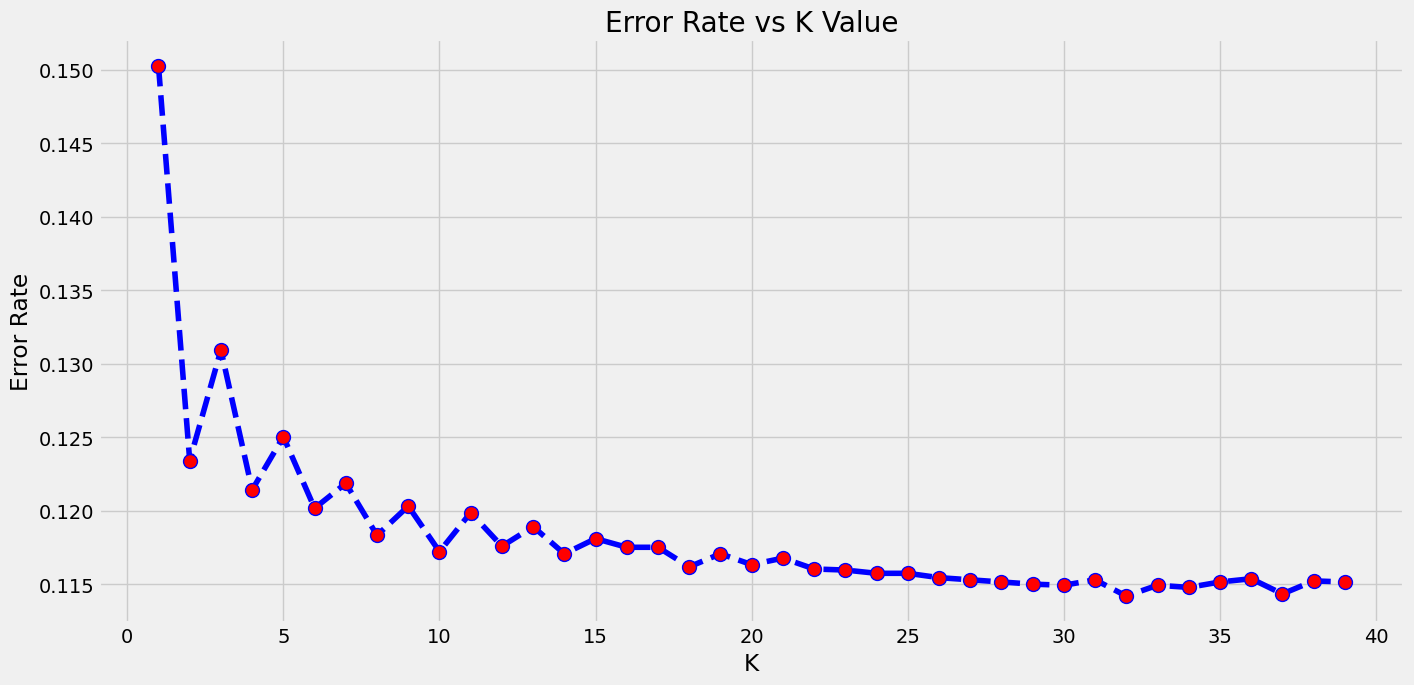

distance


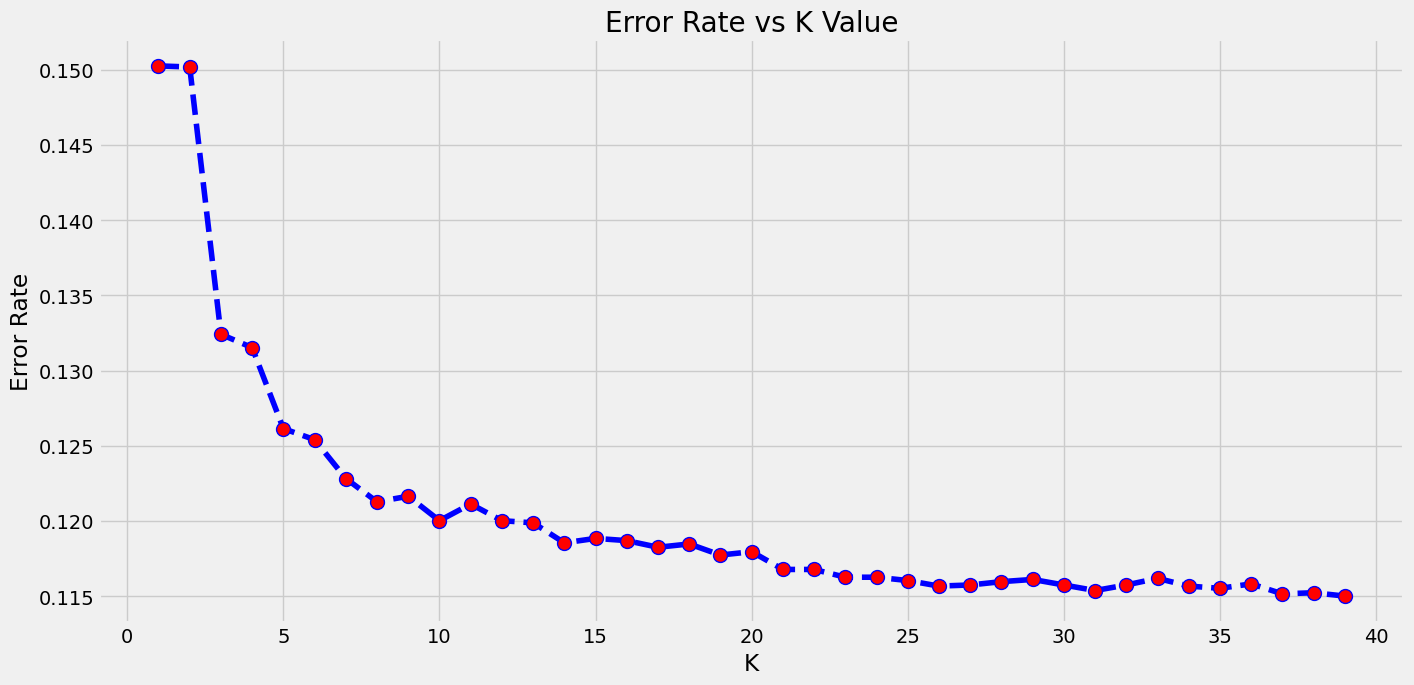

In [ ]:
#Cell 37
# Choosing a K Value
error_rate = {}
weights = ['uniform', 'distance']
for w in weights:
    print(w)
    rate = []
    for i in range(1, 40):
        knn = KNeighborsClassifier(n_neighbors = i, weights = w)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        rate.append(np.mean(y_pred != y_test))
    plt.figure(figsize = (15, 7.2))
    plt.plot(range(1, 40), rate, color = 'blue', linestyle = 'dashed', marker = 'o',
             markerfacecolor = 'red', markersize = 10)
    plt.title('Error Rate vs K Value')
    plt.xlabel('K')
    plt.ylabel('Error Rate')
    plt.show()

In [ ]:
#Cell 38
# KNN with hyperparameter tuning
kNN = KNeighborsClassifier(n_jobs = -1)

params = {'n_neighbors': list(range(3, 40, 2)), 'weights': ['uniform', 'distance']}

scoring = {'Recall': make_scorer(recall_score), 'f1_score': make_scorer(f1_score)}

skf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = random_state)

kNN_hyper = GridSearchCV(kNN, param_grid = params, n_jobs = -1, cv = skf, scoring = scoring, refit = 'f1_score')

kNN_hyper.fit(X_train, y_train)
print(kNN_hyper.best_estimator_)
print(kNN_hyper.best_params_)

KNeighborsClassifier(n_jobs=-1, n_neighbors=3, weights='distance')
{'n_neighbors': 3, 'weights': 'distance'}


In [ ]:
#Cell 39
# KNN with hyperparameter tuning
kNN_hyper = KNeighborsClassifier(algorithm = 'auto', leaf_size = 30, metric = 'minkowski', metric_params = None,
                                 n_jobs = -1, n_neighbors = 3, p = 2, weights = 'distance')
base_model = [kNN_hyper]
n_splits = 5
df1 = train_and_predict(n_splits, base_model, Xs, y, 'k-Nearest Neighbor Scaled With Hyperparameter Tuning')
df = df.append(df1)
df

Model- K-nearest neighbor scaled with hyperparameter tuning and CV- 0
--------------------
Training Score: 1.000
Test Score: 0.886
Accuracy Score: 0.886
Precision Score - Subscribe: 0.518
Recall Score - Subscribe: 0.339
f1 Score - Subscribe: 0.410
Precision Score - Macro: 0.717
Recall Score - Macro: 0.649
f1 Score - Macro: 0.673


Model- K-nearest neighbor scaled with hyperparameter tuning and CV- 1
--------------------
Training Score: 1.000
Test Score: 0.884
Accuracy Score: 0.884
Precision Score - Subscribe: 0.504
Recall Score - Subscribe: 0.328
f1 Score - Subscribe: 0.397
Precision Score - Macro: 0.709
Recall Score - Macro: 0.643
f1 Score - Macro: 0.667


Model- K-nearest neighbor scaled with hyperparameter tuning and CV- 2
--------------------
Training Score: 1.000
Test Score: 0.888
Accuracy Score: 0.888
Precision Score - Subscribe: 0.533
Recall Score - Subscribe: 0.332
f1 Score - Subscribe: 0.409
Precision Score - Macro: 0.724
Recall Score - Macro: 0.647
f1 Score - Macro: 0.673


M

Accuracy  \
Baseline Model                                         0.882   
Logistic Regression Without Hyperparameter Tuning      0.898   
Logistic Regression With Hyperparameter Tuning         0.898   
k-Nearest Neighbor Scaled Without Hyperparamete...     0.891   
k-Nearest Neighbor Scaled With Hyperparameter T...     0.886   

                                                    Precision_Subscribe  \
Baseline Model                                                    0.000   
Logistic Regression Without Hyperparameter Tuning                 0.626   
Logistic Regression With Hyperparameter Tuning                    0.623   
k-Nearest Neighbor Scaled Without Hyperparamete...                0.566   
k-Nearest Neighbor Scaled With Hyperparameter T...                0.517   

                                                    Precision_Macro  \
Baseline Model                                                0.441   
Logistic Regression Without Hyperparameter Tuning             0.771   
Logistic Regression With Hyperparameter Tuning                0.770   
k-Nearest Neighbor Scaled Without Hyperparamete...            0.739   
k-Nearest Neighbor Scaled With Hyperparameter T...            0.716   

                                                    Recall_Subscribe  \
Baseline Model                                                 0.000   
Logistic Regression Without Hyperparameter Tuning              0.327   
Logistic Regression With Hyperparameter Tuning                 0.333   
k-Nearest Neighbor Scaled Without Hyperparamete...             0.300   
k-Nearest Neighbor Scaled With Hyperparameter T...             0.330   

                                                    Recall_Macro  \
Baseline Model                                             0.500   
Logistic Regression Without Hyperparameter Tuning          0.651   
Logistic Regression With Hyperparameter Tuning             0.653   
k-Nearest Neighbor Scaled Without Hyperparamete...         0.635   
k-Nearest Neighbor Scaled With Hyperparameter T...         0.645   

                                                    f1_Subscribe  f1_Macro  
Baseline Model                                             0.000     0.469  
Logistic Regression Without Hyperparameter Tuning          0.430     0.687  
Logistic Regression With Hyperparameter Tuning             0.434     0.689  
k-Nearest Neighbor Scaled Without Hyperparamete...         0.392     0.666  
k-Nearest Neighbor Scaled With Hyperparameter T...         0.403     0.670

In [ ]:
#Cell 40
# Naive Bayes Model
NB = GaussianNB()
base_model = [NB]
n_splits = 5
df1 = train_and_predict(n_splits, base_model, X, y, 'Naive Bayes Classifier')
df = df.append(df1)
df

Model- Naive bayes classifier and CV- 0
--------------------
Training Score: 0.814
Test Score: 0.814
Accuracy Score: 0.814
Precision Score - Subscribe: 0.314
Recall Score - Subscribe: 0.498
f1 Score - Subscribe: 0.385
Precision Score - Macro: 0.621
Recall Score - Macro: 0.677
f1 Score - Macro: 0.638


Model- Naive bayes classifier and CV- 1
--------------------
Training Score: 0.816
Test Score: 0.817
Accuracy Score: 0.817
Precision Score - Subscribe: 0.328
Recall Score - Subscribe: 0.536
f1 Score - Subscribe: 0.407
Precision Score - Macro: 0.630
Recall Score - Macro: 0.695
f1 Score - Macro: 0.650


Model- Naive bayes classifier and CV- 2
--------------------
Training Score: 0.816
Test Score: 0.815
Accuracy Score: 0.815
Precision Score - Subscribe: 0.323
Recall Score - Subscribe: 0.532
f1 Score - Subscribe: 0.402
Precision Score - Macro: 0.627
Recall Score - Macro: 0.692
f1 Score - Macro: 0.646


Model- Naive bayes classifier and CV- 3
--------------------
Training Score: 0.815
Test Sco

Accuracy  \
Baseline Model                                         0.882   
Logistic Regression Without Hyperparameter Tuning      0.898   
Logistic Regression With Hyperparameter Tuning         0.898   
k-Nearest Neighbor Scaled Without Hyperparamete...     0.891   
k-Nearest Neighbor Scaled With Hyperparameter T...     0.886   
Naive Bayes Classifier                                 0.815   

                                                    Precision_Subscribe  \
Baseline Model                                                    0.000   
Logistic Regression Without Hyperparameter Tuning                 0.626   
Logistic Regression With Hyperparameter Tuning                    0.623   
k-Nearest Neighbor Scaled Without Hyperparamete...                0.566   
k-Nearest Neighbor Scaled With Hyperparameter T...                0.517   
Naive Bayes Classifier                                            0.320   

                                                    Precision_Macro  \
Baseline Model                                                0.441   
Logistic Regression Without Hyperparameter Tuning             0.771   
Logistic Regression With Hyperparameter Tuning                0.770   
k-Nearest Neighbor Scaled Without Hyperparamete...            0.739   
k-Nearest Neighbor Scaled With Hyperparameter T...            0.716   
Naive Bayes Classifier                                        0.625   

                                                    Recall_Subscribe  \
Baseline Model                                                 0.000   
Logistic Regression Without Hyperparameter Tuning              0.327   
Logistic Regression With Hyperparameter Tuning                 0.333   
k-Nearest Neighbor Scaled Without Hyperparamete...             0.300   
k-Nearest Neighbor Scaled With Hyperparameter T...             0.330   
Naive Bayes Classifier                                         0.520   

                                                    Recall_Macro  \
Baseline Model                                             0.500   
Logistic Regression Without Hyperparameter Tuning          0.651   
Logistic Regression With Hyperparameter Tuning             0.653   
k-Nearest Neighbor Scaled Without Hyperparamete...         0.635   
k-Nearest Neighbor Scaled With Hyperparameter T...         0.645   
Naive Bayes Classifier                                     0.687   

                                                    f1_Subscribe  f1_Macro  
Baseline Model                                             0.000     0.469  
Logistic Regression Without Hyperparameter Tuning          0.430     0.687  
Logistic Regression With Hyperparameter Tuning             0.434     0.689  
k-Nearest Neighbor Scaled Without Hyperparamete...         0.392     0.666  
k-Nearest Neighbor Scaled With Hyperparameter T...         0.403     0.670  
Naive Bayes Classifier                                     0.396     0.644

In [ ]:
#Cell 41
# Naive Bayes with oversampling
#!pip install smote
import smote
print(dir(smote))
NB_over = GaussianNB()
base_model = [NB_over]
n_splits = 5
df1 = train_and_predict(n_splits, base_model, X, y, 'Naive Bayes, Oversampled',
                       oversampling = True)
df = df.append(df1)
df

['NearestNeighbors', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', 'numpy', 'populate', 'smote']
Model- Naive bayes, oversampled and CV- 0
--------------------
Training Score: 0.733
Test Score: 0.717
Accuracy Score: 0.717
Precision Score - Subscribe: 0.246
Recall Score - Subscribe: 0.689
f1 Score - Subscribe: 0.363
Precision Score - Macro: 0.596
Recall Score - Macro: 0.705
f1 Score - Macro: 0.590


Model- Naive bayes, oversampled and CV- 1
--------------------
Training Score: 0.734
Test Score: 0.712
Accuracy Score: 0.712
Precision Score - Subscribe: 0.249
Recall Score - Subscribe: 0.722
f1 Score - Subscribe: 0.370
Precision Score - Macro: 0.600
Recall Score - Macro: 0.716
f1 Score - Macro: 0.592


Model- Naive bayes, oversampled and CV- 2
--------------------
Training Score: 0.735
Test Score: 0.703
Accuracy Score: 0.703
Precision Score - Subscribe: 0.241
Recall Score - Subscribe: 0.716
f1 Score - Sub

Accuracy  \
Baseline Model                                         0.882   
Logistic Regression Without Hyperparameter Tuning      0.898   
Logistic Regression With Hyperparameter Tuning         0.898   
k-Nearest Neighbor Scaled Without Hyperparamete...     0.891   
k-Nearest Neighbor Scaled With Hyperparameter T...     0.886   
Naive Bayes Classifier                                 0.815   
Naive Bayes, Oversampled                               0.716   

                                                    Precision_Subscribe  \
Baseline Model                                                    0.000   
Logistic Regression Without Hyperparameter Tuning                 0.626   
Logistic Regression With Hyperparameter Tuning                    0.623   
k-Nearest Neighbor Scaled Without Hyperparamete...                0.566   
k-Nearest Neighbor Scaled With Hyperparameter T...                0.517   
Naive Bayes Classifier                                            0.320   
Naive Bayes, Oversampled                                          0.249   

                                                    Precision_Macro  \
Baseline Model                                                0.441   
Logistic Regression Without Hyperparameter Tuning             0.771   
Logistic Regression With Hyperparameter Tuning                0.770   
k-Nearest Neighbor Scaled Without Hyperparamete...            0.739   
k-Nearest Neighbor Scaled With Hyperparameter T...            0.716   
Naive Bayes Classifier                                        0.625   
Naive Bayes, Oversampled                                      0.599   

                                                    Recall_Subscribe  \
Baseline Model                                                 0.000   
Logistic Regression Without Hyperparameter Tuning              0.327   
Logistic Regression With Hyperparameter Tuning                 0.333   
k-Nearest Neighbor Scaled Without Hyperparamete...             0.300   
k-Nearest Neighbor Scaled With Hyperparameter T...             0.330   
Naive Bayes Classifier                                         0.520   
Naive Bayes, Oversampled                                       0.707   

                                                    Recall_Macro  \
Baseline Model                                             0.500   
Logistic Regression Without Hyperparameter Tuning          0.651   
Logistic Regression With Hyperparameter Tuning             0.653   
k-Nearest Neighbor Scaled Without Hyperparamete...         0.635   
k-Nearest Neighbor Scaled With Hyperparameter T...         0.645   
Naive Bayes Classifier                                     0.687   
Naive Bayes, Oversampled                                   0.712   

                                                    f1_Subscribe  f1_Macro  
Baseline Model                                             0.000     0.469  
Logistic Regression Without Hyperparameter Tuning          0.430     0.687  
Logistic Regression With Hyperparameter Tuning             0.434     0.689  
k-Nearest Neighbor Scaled Without Hyperparamete...         0.392     0.666  
k-Nearest Neighbor Scaled With Hyperparameter T...         0.403     0.670  
Naive Bayes Classifier                                     0.396     0.644  
Naive Bayes, Oversampled                                   0.369     0.593

In [ ]:
#Cell 42
# LR model with oversampling
LR_over = LogisticRegression(C = 1, class_weight = None, dual = False, fit_intercept = True,
                              intercept_scaling = 1, l1_ratio = None, max_iter = 100,
                              multi_class = 'auto', n_jobs = -1, penalty = 'l1', random_state = 42,
                              solver = 'liblinear', tol = 0.0001, verbose = 0, warm_start = False)
base_model = [LR_over]
n_splits = 5
df1 = train_and_predict(n_splits, base_model, X, y, 'Logistic Regression, Oversampled With Hyperparameter Tuning',
                       oversampling = True)
df = df.append(df1)
df

Model- Logistic regression, oversampled with hyperparameter tuning and CV- 0
--------------------
Training Score: 0.825
Test Score: 0.828
Accuracy Score: 0.828
Precision Score - Subscribe: 0.384
Recall Score - Subscribe: 0.786
f1 Score - Subscribe: 0.516
Precision Score - Macro: 0.676
Recall Score - Macro: 0.810
f1 Score - Macro: 0.706


Model- Logistic regression, oversampled with hyperparameter tuning and CV- 1
--------------------
Training Score: 0.821
Test Score: 0.833
Accuracy Score: 0.833
Precision Score - Subscribe: 0.395
Recall Score - Subscribe: 0.803
f1 Score - Subscribe: 0.529
Precision Score - Macro: 0.682
Recall Score - Macro: 0.820
f1 Score - Macro: 0.714


Model- Logistic regression, oversampled with hyperparameter tuning and CV- 2
--------------------
Training Score: 0.826
Test Score: 0.828
Accuracy Score: 0.828
Precision Score - Subscribe: 0.385
Recall Score - Subscribe: 0.787
f1 Score - Subscribe: 0.517
Precision Score - Macro: 0.676
Recall Score - Macro: 0.810
f1 Sco

Accuracy  \
Baseline Model                                         0.882   
Logistic Regression Without Hyperparameter Tuning      0.898   
Logistic Regression With Hyperparameter Tuning         0.898   
k-Nearest Neighbor Scaled Without Hyperparamete...     0.891   
k-Nearest Neighbor Scaled With Hyperparameter T...     0.886   
Naive Bayes Classifier                                 0.815   
Naive Bayes, Oversampled                               0.716   
Logistic Regression, Oversampled With Hyperpara...     0.829   

                                                    Precision_Subscribe  \
Baseline Model                                                    0.000   
Logistic Regression Without Hyperparameter Tuning                 0.626   
Logistic Regression With Hyperparameter Tuning                    0.623   
k-Nearest Neighbor Scaled Without Hyperparamete...                0.566   
k-Nearest Neighbor Scaled With Hyperparameter T...                0.517   
Naive Bayes Classifier                                            0.320   
Naive Bayes, Oversampled                                          0.249   
Logistic Regression, Oversampled With Hyperpara...                0.387   

                                                    Precision_Macro  \
Baseline Model                                                0.441   
Logistic Regression Without Hyperparameter Tuning             0.771   
Logistic Regression With Hyperparameter Tuning                0.770   
k-Nearest Neighbor Scaled Without Hyperparamete...            0.739   
k-Nearest Neighbor Scaled With Hyperparameter T...            0.716   
Naive Bayes Classifier                                        0.625   
Naive Bayes, Oversampled                                      0.599   
Logistic Regression, Oversampled With Hyperpara...            0.677   

                                                    Recall_Subscribe  \
Baseline Model                                                 0.000   
Logistic Regression Without Hyperparameter Tuning              0.327   
Logistic Regression With Hyperparameter Tuning                 0.333   
k-Nearest Neighbor Scaled Without Hyperparamete...             0.300   
k-Nearest Neighbor Scaled With Hyperparameter T...             0.330   
Naive Bayes Classifier                                         0.520   
Naive Bayes, Oversampled                                       0.707   
Logistic Regression, Oversampled With Hyperpara...             0.786   

                                                    Recall_Macro  \
Baseline Model                                             0.500   
Logistic Regression Without Hyperparameter Tuning          0.651   
Logistic Regression With Hyperparameter Tuning             0.653   
k-Nearest Neighbor Scaled Without Hyperparamete...         0.635   
k-Nearest Neighbor Scaled With Hyperparameter T...         0.645   
Naive Bayes Classifier                                     0.687   
Naive Bayes, Oversampled                                   0.712   
Logistic Regression, Oversampled With Hyperpara...         0.811   

                                                    f1_Subscribe  f1_Macro  
Baseline Model                                             0.000     0.469  
Logistic Regression Without Hyperparameter Tuning          0.430     0.687  
Logistic Regression With Hyperparameter Tuning             0.434     0.689  
k-Nearest Neighbor Scaled Without Hyperparamete...         0.392     0.666  
k-Nearest Neighbor Scaled With Hyperparameter T...         0.403     0.670  
Naive Bayes Classifier                                     0.396     0.644  
Naive Bayes, Oversampled                                   0.369     0.593  
Logistic Regression, Oversampled With Hyperpara...         0.518     0.707